
1. Import Library

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pywt
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
import itertools


2. Channel Coords

In [14]:
channel_coords = {
    "FT7": (-0.8,  0.6),
    "FT8": ( 0.8,  0.6),
    "T7" : (-1.0,  0.3),
    "C5" : (-0.5,  0.2),
    "C6" : ( 0.5,  0.2),
    "T8" : ( 1.0,  0.3),
    "TP7": (-0.9, -0.2),
    "CP5": (-0.4, -0.3),
    "CP6": ( 0.4, -0.3),
    "TP8": ( 0.9, -0.2),
    "P7" : (-0.7, -0.6),
    "P8" : ( 0.7, -0.6),
}
channels = list(channel_coords.keys())

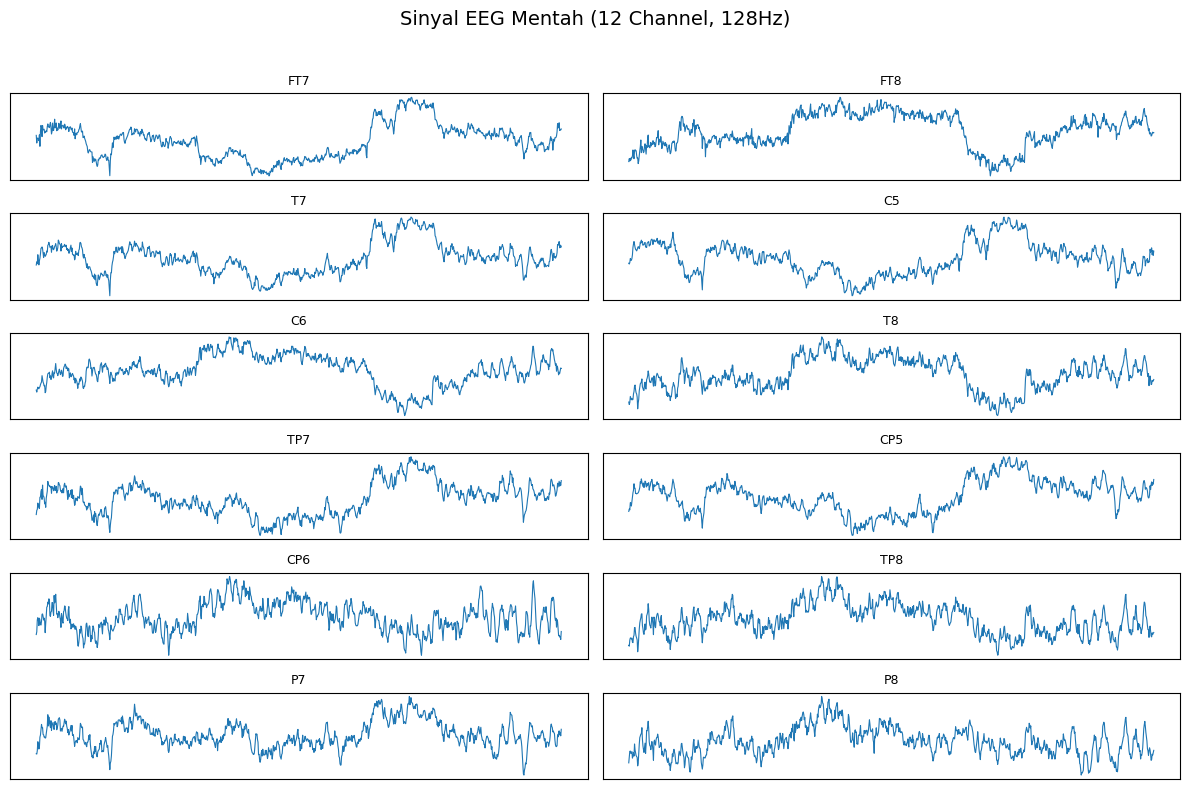

In [ ]:
# Baca file CSV contoh (misalnya kelas Netral)
csv_path = "./Segmentasi 5 detik/EmosiNetral/EmosiNetral0_0.csv"
df = pd.read_csv(csv_path)

# Channel yang dipakai (12 channel dari channel_coords)
channels = ["FT7","FT8","T7","C5","C6","T8",
            "TP7","CP5","CP6","TP8","P7","P8"]

# Plot sinyal mentah untuk semua channel
plt.figure(figsize=(12, 8))
for i, ch in enumerate(channels):
    plt.subplot(6, 2, i+1)
    plt.plot(df[ch].values[:1000], linewidth=0.8)
    plt.title(ch, fontsize=9)
    plt.xticks([]); plt.yticks([])

plt.suptitle("Sinyal EEG Mentah (12 Channel, 128Hz)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Extract DWT Features

In [8]:
def extract_dwt_de(segment, wavelet="db4", level=5):
    """
    segment: (n_channels, n_times)
    return : (n_channels, 5) [delta, theta, alpha, beta, gamma]
    pakai Differential Entropy (log-variance)
    """
    n_ch, _ = segment.shape
    feats = np.zeros((n_ch, 5), dtype=np.float32)
    def logp(x): return np.log(np.var(x) + 1e-6)

    for ch in range(n_ch):
        coeffs = pywt.wavedec(segment[ch], wavelet=wavelet, level=level)
        cA5, cD5, cD4, cD3, cD2, cD1 = coeffs
        feats[ch, 0] = logp(cA5)                  # Delta 0–4 Hz
        feats[ch, 1] = logp(cD5)                  # Theta 4–8 Hz
        feats[ch, 2] = logp(cD4)                  # Alpha 8–16 Hz
        feats[ch, 3] = logp(cD3)                  # Beta 16–32 Hz
        feats[ch, 4] = logp(np.hstack([cD2,cD1])) # Gamma >32 Hz
    return feats

4. Topomap

In [ ]:
def generate_topomap(values, grid_res=64):
    coords = np.array([channel_coords[ch] for ch in channels])
    xi = np.linspace(-1, 1, grid_res)
    yi = np.linspace(-1, 1, grid_res)
    xx, yy = np.meshgrid(xi, yi)
    zi = griddata(coords, values, (xx, yy), method="linear", fill_value=np.nan)
    zi = np.nan_to_num(zi)
    return zi

def eeg_to_topomap_image(segment, grid_res=64):
    # segment: (n_channels, n_bands)
    planes = []
    for i in range(segment.shape[1]): 
        topo = generate_topomap(segment[:, i], grid_res)
        planes.append(topo)
    img = np.stack(planes, axis=0)
    return img.astype(np.float32)

In [ ]:
BAND_NAMES = ["delta", "theta", "alpha", "beta", "gamma"]

def plot_band_channel_heatmap(feats):
    """
    feats: (n_channels, 5) urutan [delta, theta, alpha, beta, gamma] per channel
    Membuat heatmap Bands x Channels (langsung tampil).
    """
    mat = feats.T.astype(np.float32)  # (5, n_channels)

    eps = 1e-8
    mat = (mat - mat.min(axis=1, keepdims=True)) / (
        mat.max(axis=1, keepdims=True) - mat.min(axis=1, keepdims=True) + eps
    )

    plt.figure(figsize=(10, 2.8))
    plt.imshow(mat, aspect="auto")
    plt.yticks(ticks=np.arange(len(BAND_NAMES)), labels=BAND_NAMES)
    plt.xticks(ticks=np.arange(len(channels)), labels=channels, rotation=45, ha="right")
    plt.xlabel("Channels")
    plt.ylabel("Frequency Bands")
    plt.title("Representasi 2D EEG (Bandpower DWT-DE: Bands × Channels)")
    plt.colorbar(label="Normalized Power")
    plt.tight_layout()
    plt.show()


def plot_topomap_per_band(feats, grid_res=64):
    """
    feats: (n_channels, 5) urutan [delta, theta, alpha, beta, gamma]
    Membuat 5 sub-plot topomap (langsung tampil).
    """
    n_bands = feats.shape[1]
    fig, axes = plt.subplots(1, n_bands, figsize=(3.2*n_bands, 3.2))
    if n_bands == 1:
        axes = [axes]

    for i in range(n_bands):
        topo = generate_topomap(feats[:, i], grid_res=grid_res)
        ax = axes[i]
        im = ax.imshow(topo, origin="lower", aspect="equal")
        ax.set_title(BAND_NAMES[i])
        ax.set_xticks([]); ax.set_yticks([])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    fig.suptitle("Topomap per Band (Interpolasi kanal → grid 2D)", y=1.02)
    plt.tight_layout()
    plt.show()


def show_preprocessing_figures_from_csv(csv_path, wavelet="db4", level=5):
    """
    Ambil 1 file CSV → hitung DWT-DE → tampilkan heatmap & topomap.
    """
    df = pd.read_csv(csv_path)
    data = df[channels].values.T  # (12, n_times)
    feats = extract_dwt_de(data, wavelet=wavelet, level=level)

    plot_band_channel_heatmap(feats)
    plot_topomap_per_band(feats, grid_res=64)


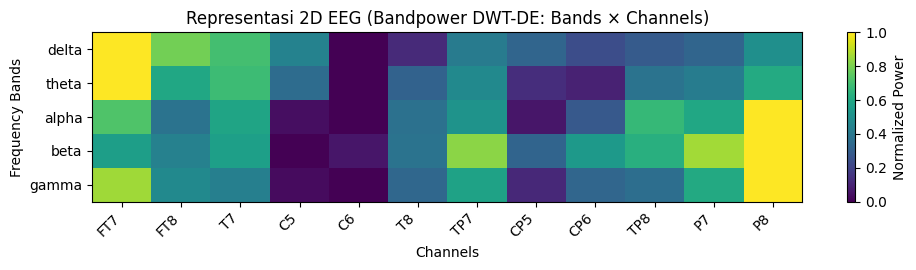

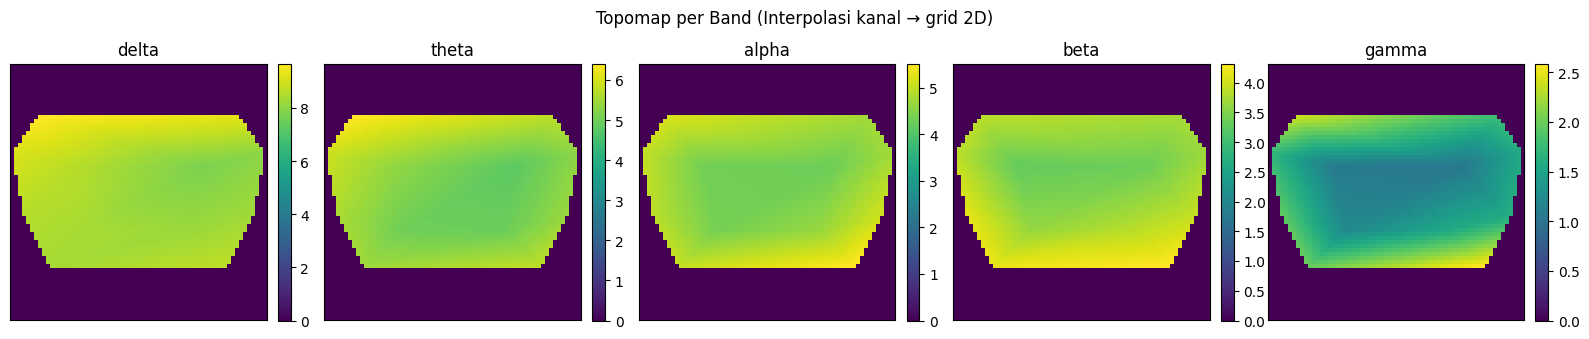

In [ ]:
# Contoh Data sebelum Training
sample_csv = "./Segmentasi 5 detik/EmosiNegatif/EmosiNegatif0_7.csv" 
show_preprocessing_figures_from_csv(sample_csv)


5. Convert Dataset to npz

In [12]:
def convert_csv_folder_to_npz(folder_path, out_file, wavelet="db4"):
    all_X, all_y = [], []
    label_map = {"EmosiNegatif":0, "EmosiNetral":1, "EmosiPositif":2}

    for emo_class, label in label_map.items():
        class_dir = os.path.join(folder_path, emo_class)
        for fname in os.listdir(class_dir):
            if fname.endswith(".csv"):
                fpath = os.path.join(class_dir, fname)
                df = pd.read_csv(fpath)
                data = df[channels].values.T   # (12, n_times)
                feats = extract_dwt_de(data, wavelet=wavelet, level=5)
                all_X.append(feats)
                all_y.append(label)

    X = np.array(all_X, dtype=np.float32)
    y = np.array(all_y, dtype=np.int64)

    idx = np.arange(len(X))
    np.random.shuffle(idx)
    X, y = X[idx], y[idx]

    np.savez_compressed(out_file, X=X, y=y)
    print(f"Saved {out_file} with shape X={X.shape}, y={y.shape}")

In [46]:
convert_csv_folder_to_npz(
    folder_path="./Segmentasi 5 detik/",
    out_file="./npz_output/seed_segmentasi5detik_dwt_de.npz"
)

Saved ./npz_output/seed_segmentasi5detik_dwt_de.npz with shape X=(24975, 12, 5), y=(24975,)


In [ ]:
#Tanpa DWT
# def convert_csv_folder_to_npz_raw(folder_path, out_file):
#     all_X, all_y = [], []
#     label_map = {"EmosiNegatif":0, "EmosiNetral":1, "EmosiPositif":2}

#     for emo_class, label in label_map.items():
#         class_dir = os.path.join(folder_path, emo_class)
#         for fname in os.listdir(class_dir):
#             if fname.endswith(".csv"):
#                 fpath = os.path.join(class_dir, fname)
#                 df = pd.read_csv(fpath)
#                 data = df[channels].values.T  # (12, n_times)
#                 # potong agar panjangnya konsisten (opsional)
#                 if data.shape[1] > 1024:
#                     data = data[:, :1024]
#                 # normalisasi per kanal
#                 data = (data - np.mean(data, axis=1, keepdims=True)) / (np.std(data, axis=1, keepdims=True) + 1e-6)
#                 all_X.append(data)
#                 all_y.append(label)

#     X = np.array(all_X, dtype=np.float32)
#     y = np.array(all_y, dtype=np.int64)
#     idx = np.arange(len(X))
#     np.random.shuffle(idx)
#     X, y = X[idx], y[idx]
#     np.savez_compressed(out_file, X=X, y=y)
#     print(f"Saved {out_file} with shape X={X.shape}, y={y.shape}")

# convert_csv_folder_to_npz_raw(
#     folder_path="./Segmentasi 5 detik/",
#     out_file="./npz_output/seed_segmentasi5detik_raw.npz"
# )


Saved ./npz_output/seed_segmentasi5detik_raw.npz with shape X=(24975, 12, 1000), y=(24975,)


In [3]:
d = np.load("./npz_output/seed_segmentasi5detik_dwt_de.npz")
print(np.unique(d["y"], return_counts=True))


(array([0, 1, 2]), array([8325, 8325, 8325]))


6. Dataset Class

In [4]:
class SEEDTopomapDataset(Dataset):
    def __init__(self, npz_file, indices=None, train=False, mean=None, std=None, resize=(32,32)):
        d = np.load(npz_file)
        X, y = d["X"], d["y"]
        if indices is None: self.X, self.y = X, y
        else: self.X, self.y = X[indices], y[indices]
        self.train = train
        self.mean = None if mean is None else mean.astype(np.float32)
        self.std  = None if std  is None else (std.astype(np.float32) + 1e-6)
        self.resize = resize

    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        X = self.X[idx]; y = int(self.y[idx])
        if self.mean is not None:
            X = (X - self.mean) / self.std
        img = eeg_to_topomap_image(X, grid_res=self.resize[0])  # (bands,H,W)
        return torch.tensor(img, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [ ]:
#Tanpa DWT
# class SEEDTopomapDatasetRaw(Dataset):
#     def __init__(self, npz_file, indices=None, mean=None, std=None, resize=(32,32)):
#         d = np.load(npz_file)
#         X, y = d["X"], d["y"]
#         if indices is None: self.X, self.y = X, y
#         else: self.X, self.y = X[indices], y[indices]
#         self.mean = mean
#         self.std = std
#         self.resize = resize

#     def __len__(self): return len(self.X)

#     def __getitem__(self, idx):
#         data = self.X[idx]  # (12, n_times)
#         label = int(self.y[idx])
#         # Normalisasi global
#         if self.mean is not None:
#             data = (data - self.mean) / (self.std + 1e-6)
#         # ubah ke bentuk "5-channel imitasi" biar sesuai input CNN (misal pakai 5 potongan frekuensi semu)
#         segs = np.array_split(data, 5, axis=1)  # jadi 5 bagian waktu
#         feats = np.array([s.mean(axis=1) for s in segs])  # (5, 12)
#         img = eeg_to_topomap_image(feats.T, grid_res=self.resize[0])  # (bands,H,W)
#         return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


7. Model

In [5]:
class DeepCNNBackbone(nn.Module):
    def __init__(self, in_channels=5, out_channels=256):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.AdaptiveAvgPool2d((8,8))
        )
        self.proj = nn.Conv2d(512, out_channels, 1)
    def forward(self, x):
        return self.proj(self.features(x))


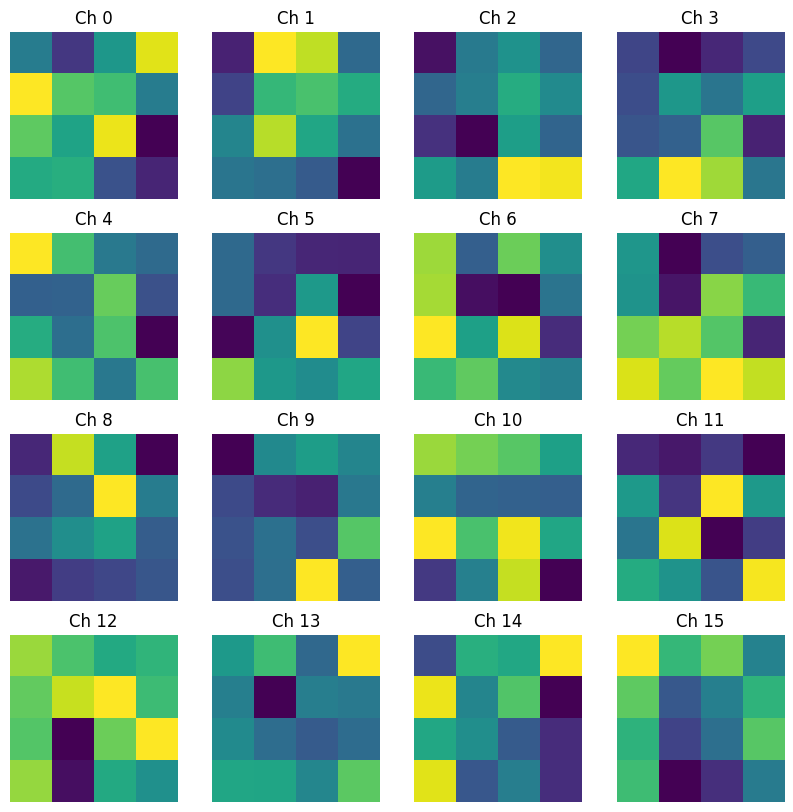

In [ ]:
import torch
import matplotlib.pyplot as plt

backbone = DeepCNNBackbone(in_channels=5, out_channels=256)
x = torch.randn(1, 5, 32, 32)
feat = backbone(x)[0].detach().cpu()   # shape (256, 8, 8)

# visualisasi 16 feature map pertama
plt.figure(figsize=(10, 10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(feat[i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Ch {i}')
plt.show()


In [ ]:
# class HybridCNNViT(nn.Module):   59%
#     def __init__(self, in_channels=5, emb_dim=128, num_heads=4,
#                  num_layers=2, num_classes=3, dropout=0.1):  # ⬅️ num_classes=3
#         super().__init__()
#         self.backbone = DeepCNNBackbone(in_channels=in_channels, out_channels=emb_dim)
#         self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
#         self.pos_embed = nn.Parameter(torch.randn(1, 1+64, emb_dim))  # 8x8 patches
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=emb_dim, nhead=num_heads,
#             dim_feedforward=emb_dim*2,
#             dropout=dropout, activation="gelu", batch_first=True
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
#         self.mlp_head = nn.Sequential(
#             nn.LayerNorm(emb_dim),
#             nn.Linear(emb_dim, num_classes)
#         )

#     def forward(self, x):
#         B = x.size(0)
#         feat = self.backbone(x)                  # (B, emb_dim, 8, 8)
#         tokens = feat.flatten(2).permute(0,2,1)  # (B,64,emb_dim)
#         cls = self.cls_token.expand(B, -1, -1)   # (B,1,emb_dim)
#         toks = torch.cat([cls, tokens], dim=1)   # (B,65,emb_dim)
#         toks = toks + self.pos_embed[:, :toks.size(1), :]
#         out = self.transformer(toks)             # (B,65,emb_dim)
#         cls_out = out[:,0]                       # (B,emb_dim)
#         return self.mlp_head(cls_out)

#stack 33%
# class HybridCNNViT_Improved(nn.Module):
#     def __init__(self, in_channels=5, emb_dim=256, num_heads=8,
#                  num_layers=2, num_classes=3, dropout=0.05):
#         super().__init__()
#         # CNN backbone
#         self.backbone = DeepCNNBackbone(in_channels=in_channels, out_channels=emb_dim)

#         # Positional embedding & CLS token
#         self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))
#         self.pos_embed = nn.Parameter(torch.randn(1, 1+64, emb_dim))  # 8x8 patches

#         # Transformer encoder
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=emb_dim, nhead=num_heads,
#             dim_feedforward=emb_dim*2,
#             dropout=dropout, activation="gelu", batch_first=True
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # MLP head lebih dalam
#         self.mlp_head = nn.Sequential(
#             nn.LayerNorm(emb_dim),
#             nn.Linear(emb_dim, emb_dim//2),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(emb_dim//2, num_classes)
#         )

#     def forward(self, x):
#         B = x.size(0)
#         feat = self.backbone(x)                  # (B, emb_dim, 8, 8)
#         tokens = feat.flatten(2).permute(0,2,1)  # (B,64,emb_dim)
#         cls = self.cls_token.expand(B, -1, -1)   # (B,1,emb_dim)
#         toks = torch.cat([cls, tokens], dim=1)   # (B,65,emb_dim)
#         toks = toks + self.pos_embed[:, :toks.size(1), :]
#         out = self.transformer(toks)             # (B,65,emb_dim)
#         cls_out = out[:,0]                       # (B,emb_dim)
#         return self.mlp_head(cls_out)

#84%
# class HybridCNNViT_Simple(nn.Module):
#     def __init__(self, in_channels=5, emb_dim=128, num_heads=2,
#                  num_layers=1, num_classes=3):
#         super().__init__()
#         self.backbone = DeepCNNBackbone(in_channels=in_channels, out_channels=emb_dim)
#         self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

#         # Transformer ringan
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=emb_dim, nhead=num_heads,
#             dim_feedforward=emb_dim*2,
#             dropout=0.0, activation="gelu", batch_first=True
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # Head sederhana
#         self.mlp_head = nn.Sequential(
#             nn.LayerNorm(emb_dim),
#             nn.Linear(emb_dim, num_classes)
#         )

#     def forward(self, x):
#         B = x.size(0)
#         feat = self.backbone(x)                  # (B, emb_dim, 8, 8)
#         tokens = feat.flatten(2).permute(0,2,1)  # (B,64,emb_dim)
#         cls = self.cls_token.expand(B, -1, -1)   # (B,1,emb_dim)
#         toks = torch.cat([cls, tokens], dim=1)   # (B,65,emb_dim)
#         out = self.transformer(toks)             # (B,65,emb_dim)
#         cls_out = out[:,0]                       # (B,emb_dim)
#         return self.mlp_head(cls_out)

In [6]:
#85%
class HybridCNNViT_SimplePE(nn.Module):
    def __init__(self, in_channels=5, emb_dim=128, num_heads=2,
                 num_layers=1, num_classes=3, dropout=0.0):
        super().__init__()
        self.backbone = DeepCNNBackbone(in_channels=in_channels, out_channels=emb_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim) * 0.02)
        # +1 untuk CLS; init = 0 agar awalnya tidak “mengacak” fitur CNN
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + 64, emb_dim))

        enc = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=num_heads,
            dim_feedforward=emb_dim*2,
            dropout=dropout, activation="gelu",
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(enc, num_layers=num_layers)
        self.mlp_head = nn.Sequential(nn.LayerNorm(emb_dim), nn.Linear(emb_dim, num_classes))

    def forward(self, x):
        B = x.size(0)
        feat = self.backbone(x)                    # (B, emb_dim, 8, 8)
        tokens = feat.flatten(2).permute(0, 2, 1)  # (B, 64, emb_dim)
        cls = self.cls_token.expand(B, -1, -1)     # (B, 1, emb_dim)
        toks = torch.cat([cls, tokens], dim=1)     # (B, 65, emb_dim)
        toks = toks + self.pos_embed[:, :toks.size(1), :]  # Patch + Position Embedding
        out = self.transformer(toks)               # (B, 65, emb_dim)
        return self.mlp_head(out[:, 0, :])         # CLS → MLP Head → logits


In [ ]:
# class CNNOnlyModel(nn.Module):
#     def __init__(self, in_channels=5, num_classes=3):
#         super().__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(in_channels, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
#             nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
#             nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2),
#             nn.Conv2d(256, 512, 3, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1,1))
#         )
#         self.classifier = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
#             nn.Linear(256, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         return self.classifier(x)

In [ ]:
# class ViTOnly(nn.Module):
#     def __init__(self, in_channels=5, emb_dim=128, patch_size=4,
#                  num_heads=2, num_layers=2, num_classes=3, dropout=0.1):
#         super().__init__()
#         self.patch_size = patch_size
#         self.emb_dim = emb_dim

#         # Conv patch embedding
#         self.patch_embed = nn.Conv2d(
#             in_channels, emb_dim,
#             kernel_size=patch_size, stride=patch_size
#         )  # output: (B, emb_dim, H/patch, W/patch)

#         num_patches = (32 // patch_size) ** 2  # misal 32x32 jadi 64 patch
#         self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim) * 0.02)
#         self.pos_embed = nn.Parameter(torch.zeros(1, 1 + num_patches, emb_dim))

#         # Transformer Encoder
#         encoder_layer = nn.TransformerEncoderLayer(
#             d_model=emb_dim, nhead=num_heads,
#             dim_feedforward=emb_dim * 2,
#             dropout=dropout, activation="gelu",
#             batch_first=True
#         )
#         self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # Classifier
#         self.mlp_head = nn.Sequential(
#             nn.LayerNorm(emb_dim),
#             nn.Linear(emb_dim, num_classes)
#         )

#     def forward(self, x):
#         # x: (B, 5, 32, 32)
#         patches = self.patch_embed(x)  # (B, emb_dim, H', W')
#         patches = patches.flatten(2).permute(0, 2, 1)  # (B, N_patches, emb_dim)

#         B = x.size(0)
#         cls = self.cls_token.expand(B, -1, -1)
#         toks = torch.cat([cls, patches], dim=1)
#         toks = toks + self.pos_embed[:, :toks.size(1), :]

#         out = self.transformer(toks)
#         logits = self.mlp_head(out[:, 0])
#         return logits


In [ ]:

# 59%
# def train_model_hybrid(npz_file, epochs=30, batch_size=16, lr=1e-3, resize=32, seed=42):
#     torch.manual_seed(seed)
#     np.random.seed(seed)
#     device = "cuda" if torch.cuda.is_available() else "cpu"

#     # load dataset
#     d = np.load(npz_file)
#     X, y = d["X"], d["y"]; N = len(X)
#     idx = np.arange(N); np.random.shuffle(idx)
#     train_idx, test_idx = idx[:int(0.8*N)], idx[int(0.8*N):]

#     # normalisasi pakai train only
#     mean, std = X[train_idx].mean(axis=0), X[train_idx].std(axis=0) + 1e-6

#     train_set = SEEDTopomapDataset(npz_file, indices=train_idx, train=True,
#                                    mean=mean, std=std, resize=(resize,resize))
#     test_set  = SEEDTopomapDataset(npz_file, indices=test_idx, train=False,
#                                    mean=mean, std=std, resize=(resize,resize))

#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
#                               num_workers=2, pin_memory=True)
#     test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False,
#                               num_workers=2, pin_memory=True)

#     # model Hybrid CNN + ViT
#     model = HybridCNNViT(in_channels=5, emb_dim=128, num_heads=4,
#                          num_layers=2, num_classes=3, dropout=0.1).to(device)

#     opt = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
#     loss_fn = nn.CrossEntropyLoss()

#     best_acc = 0.0
#     for ep in range(epochs):
#         # ---- training ----
#         model.train(); total_loss=0
#         for xb,yb in train_loader:
#             xb,yb = xb.to(device), yb.to(device)
#             opt.zero_grad()
#             logits = model(xb)
#             loss = loss_fn(logits, yb)
#             loss.backward(); opt.step()
#             total_loss += loss.item()
#         avg_loss = total_loss/len(train_loader)

#         # ---- evaluasi ----
#         model.eval(); all_preds=[]; all_labels=[]
#         with torch.no_grad():
#             for xb,yb in test_loader:
#                 xb,yb = xb.to(device), yb.to(device)
#                 preds = model(xb).argmax(1)
#                 all_preds.extend(preds.cpu().numpy())
#                 all_labels.extend(yb.cpu().numpy())
#         acc = accuracy_score(all_labels, all_preds)
#         best_acc = max(best_acc, acc)
#         print(f"Epoch {ep+1}/{epochs} - loss {avg_loss:.4f} - acc {acc:.4f} (best {best_acc:.4f})")

#     print("\n=== Final Test Report (Hybrid CNN+ViT) ===")
#     print(classification_report(all_labels, all_preds, target_names=['Negatif','Netral','Positif']))
#     print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))
#     return model

# 33%
# def train_model_hybrid_improved(npz_file, epochs=50, batch_size=16, lr=1e-3, resize=32, seed=42):
#     torch.manual_seed(seed)
#     np.random.seed(seed)
#     device = "cuda" if torch.cuda.is_available() else "cpu"

#     # load dataset
#     d = np.load(npz_file)
#     X, y = d["X"], d["y"]; N = len(X)
#     idx = np.arange(N); np.random.shuffle(idx)
#     train_idx, test_idx = idx[:int(0.8*N)], idx[int(0.8*N):]

#     # normalisasi pakai train only
#     mean, std = X[train_idx].mean(axis=0), X[train_idx].std(axis=0) + 1e-6

#     train_set = SEEDTopomapDataset(npz_file, indices=train_idx, train=True,
#                                    mean=mean, std=std, resize=(resize,resize))
#     test_set  = SEEDTopomapDataset(npz_file, indices=test_idx, train=False,
#                                    mean=mean, std=std, resize=(resize,resize))

#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
#                               num_workers=2, pin_memory=True)
#     test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False,
#                               num_workers=2, pin_memory=True)

#     # improved model
#     model = HybridCNNViT_Improved(in_channels=5, emb_dim=256,
#                                   num_heads=8, num_layers=2,
#                                   num_classes=3, dropout=0.05).to(device)

#     opt = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
#     loss_fn = nn.CrossEntropyLoss()

#     best_acc = 0.0
#     for ep in range(epochs):
#         # ---- training ----
#         model.train(); total_loss=0
#         for xb,yb in train_loader:
#             xb,yb = xb.to(device), yb.to(device)
#             opt.zero_grad()
#             logits = model(xb)
#             loss = loss_fn(logits, yb)
#             loss.backward(); opt.step()
#             total_loss += loss.item()
#         avg_loss = total_loss/len(train_loader)

#         # ---- evaluasi ----
#         model.eval(); all_preds=[]; all_labels=[]
#         with torch.no_grad():
#             for xb,yb in test_loader:
#                 xb,yb = xb.to(device), yb.to(device)
#                 preds = model(xb).argmax(1)
#                 all_preds.extend(preds.cpu().numpy())
#                 all_labels.extend(yb.cpu().numpy())
#         acc = accuracy_score(all_labels, all_preds)
#         best_acc = max(best_acc, acc)
#         print(f"Epoch {ep+1}/{epochs} - loss {avg_loss:.4f} - acc {acc:.4f} (best {best_acc:.4f})")

#     print("\n=== Final Test Report (Hybrid CNN+ViT Improved) ===")
#     print(classification_report(all_labels, all_preds, target_names=['Negatif','Netral','Positif']))
#     print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))
#     return model


In [20]:
#85%
import torch
import time
from torch.optim import Adam, AdamW, Adamax, NAdam, RMSprop
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_model_hybrid_simple(npz_file, optimizer_type="adamw", epochs=30, batch_size=16, lr=1e-4, resize=32, seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # load dataset
    d = np.load(npz_file)
    X, y = d["X"], d["y"]; N = len(X)
    idx = np.arange(N); np.random.shuffle(idx)
    train_idx, test_idx = idx[:int(0.8*N)], idx[int(0.8*N):]

    # normalisasi pakai train only
    mean, std = X[train_idx].mean(axis=0), X[train_idx].std(axis=0) + 1e-6

    train_set = SEEDTopomapDataset(npz_file, indices=train_idx, train=True,
                                   mean=mean, std=std, resize=(resize,resize))
    test_set  = SEEDTopomapDataset(npz_file, indices=test_idx, train=False,
                                   mean=mean, std=std, resize=(resize,resize))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,
                              num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False,
                              num_workers=2, pin_memory=True)

    # model hybrid simple
    model = HybridCNNViT_SimplePE(in_channels=5, emb_dim=128,
                                num_heads=2, num_layers=1,
                                num_classes=3).to(device)

    # === Pilihan optimizer fleksibel ===
    opt_type = optimizer_type.lower()
    if opt_type == "adam":
        opt = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    elif opt_type == "adamw":
        opt = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    elif opt_type == "adamax":
        opt = Adamax(model.parameters(), lr=lr, weight_decay=1e-4)
    elif opt_type == "nadam":
        opt = NAdam(model.parameters(), lr=lr, weight_decay=1e-4)
    elif opt_type == "rmsprop":
        opt = RMSprop(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    else:
        raise ValueError(f"Optimizer '{optimizer_type}' belum didukung!")

    loss_fn = nn.CrossEntropyLoss()
    best_acc = 0.0
    start_time = time.time()

    print(f"\n🚀 Training pakai optimizer: {optimizer_type.upper()}")
    for ep in range(epochs):
        ep_start = time.time()
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        # Evaluasi
        model.eval(); all_preds = []; all_labels = []
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(yb.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        best_acc = max(best_acc, acc)
        print(f"Epoch {ep+1}/{epochs} - loss {avg_loss:.4f} - acc {acc:.4f} (best {best_acc:.4f}) - time {time.time()-ep_start:.2f}s")

    total_time = time.time() - start_time
    print(f"\n🕒 Total training time: {total_time/60:.2f} minutes ({total_time:.1f} seconds)")
    print(f"✅ Best accuracy: {best_acc:.4f}")

    print(f"\n=== Final Test Report ({optimizer_type.upper()}) ===")
    print(classification_report(all_labels, all_preds, target_names=['Negatif','Netral','Positif']))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))
    return model, total_time, best_acc



In [ ]:
#Tanpa DWT

# import time

# def train_model_hybrid_no_dwt(npz_file, epochs=30, batch_size=16, lr=1e-4, resize=32, seed=42):
#     torch.manual_seed(seed)
#     np.random.seed(seed)
#     device = "cuda" if torch.cuda.is_available() else "cpu"

#     d = np.load(npz_file)
#     X, y = d["X"], d["y"]; N = len(X)
#     idx = np.arange(N); np.random.shuffle(idx)
#     train_idx, test_idx = idx[:int(0.8*N)], idx[int(0.8*N):]
#     mean, std = X[train_idx].mean(), X[train_idx].std()

#     train_set = SEEDTopomapDatasetRaw(npz_file, indices=train_idx, mean=mean, std=std, resize=(resize,resize))
#     test_set  = SEEDTopomapDatasetRaw(npz_file, indices=test_idx, mean=mean, std=std, resize=(resize,resize))

#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
#     test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

#     model = HybridCNNViT_SimplePE(in_channels=5, emb_dim=128, num_heads=2,
#                                   num_layers=1, num_classes=3).to(device)
#     opt = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
#     loss_fn = nn.CrossEntropyLoss()

#     best_acc = 0.0
#     start_time = time.time()

#     for ep in range(epochs):
#         model.train(); total_loss = 0
#         for xb, yb in train_loader:
#             xb, yb = xb.to(device), yb.to(device)
#             opt.zero_grad()
#             loss = loss_fn(model(xb), yb)
#             loss.backward(); opt.step()
#             total_loss += loss.item()
#         avg_loss = total_loss / len(train_loader)

#         model.eval(); preds, labels = [], []
#         with torch.no_grad():
#             for xb, yb in test_loader:
#                 xb, yb = xb.to(device), yb.to(device)
#                 p = model(xb).argmax(1)
#                 preds.extend(p.cpu().numpy())
#                 labels.extend(yb.cpu().numpy())
#         acc = accuracy_score(labels, preds)
#         best_acc = max(best_acc, acc)
#         print(f"Epoch {ep+1}/{epochs} - loss {avg_loss:.4f} - acc {acc:.4f} (best {best_acc:.4f})")

#     end_time = time.time()
#     print(f"\n🕒 Total training time: {(end_time-start_time)/60:.2f} minutes")

#     print("\n=== Final Test Report (Hybrid CNN+ViT No DWT) ===")
#     print(classification_report(labels, preds, target_names=['Negatif','Netral','Positif']))
#     print("Confusion Matrix:\n", confusion_matrix(labels, preds))
#     return model


In [ ]:
# import time  # ⏱️ tambahkan di bagian import atas

# def train_cnn_only(npz_file, epochs=30, batch_size=16, lr=1e-4, resize=32, seed=42):
#     torch.manual_seed(seed)
#     np.random.seed(seed)
#     device = "cuda" if torch.cuda.is_available() else "cpu"

#     d = np.load(npz_file)
#     X, y = d["X"], d["y"]; N = len(X)
#     idx = np.arange(N); np.random.shuffle(idx)
#     train_idx, test_idx = idx[:int(0.8*N)], idx[int(0.8*N):]
#     mean, std = X[train_idx].mean(axis=0), X[train_idx].std(axis=0) + 1e-6

#     train_set = SEEDTopomapDataset(npz_file, indices=train_idx, mean=mean, std=std, resize=(resize,resize))
#     test_set  = SEEDTopomapDataset(npz_file, indices=test_idx, mean=mean, std=std, resize=(resize,resize))
#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
#     test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

#     model = CNNOnlyModel(in_channels=5, num_classes=3).to(device)
#     opt = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
#     loss_fn = nn.CrossEntropyLoss()

#     best_acc = 0.0
#     start_time = time.time()  # 🕒 mulai hitung waktu total

#     for ep in range(epochs):
#         epoch_start = time.time()  # (opsional) waktu per epoch

#         model.train(); total_loss = 0
#         for xb, yb in train_loader:
#             xb, yb = xb.to(device), yb.to(device)
#             opt.zero_grad()
#             loss = loss_fn(model(xb), yb)
#             loss.backward(); opt.step()
#             total_loss += loss.item()
#         avg_loss = total_loss / len(train_loader)

#         model.eval(); preds, labels = [], []
#         with torch.no_grad():
#             for xb, yb in test_loader:
#                 xb, yb = xb.to(device), yb.to(device)
#                 p = model(xb).argmax(1)
#                 preds.extend(p.cpu().numpy()); labels.extend(yb.cpu().numpy())

#         acc = accuracy_score(labels, preds)
#         best_acc = max(best_acc, acc)

#         epoch_end = time.time()  # (opsional) selesai epoch
#         print(f"Epoch {ep+1}/{epochs} - loss {avg_loss:.4f} - acc {acc:.4f} (best {best_acc:.4f}) - time {(epoch_end - epoch_start):.2f}s")

#     end_time = time.time()  # 🕒 selesai hitung waktu total
#     total_time = end_time - start_time
#     print(f"\n🕒 Total training time: {total_time/60:.2f} minutes ({total_time:.1f} seconds)")

#     print("\n=== Final Test Report (CNN Only) ===")
#     print(classification_report(labels, preds, target_names=['Negatif','Netral','Positif']))
#     print("Confusion Matrix:\n", confusion_matrix(labels, preds))
#     return model, total_time


In [ ]:
# import time  # ⏱️ tambahkan di bagian import atas

# def train_model_vit_only(npz_file, epochs=30, batch_size=16, lr=1e-4, resize=32, seed=42):
#     torch.manual_seed(seed)
#     np.random.seed(seed)
#     device = "cuda" if torch.cuda.is_available() else "cpu"

#     d = np.load(npz_file)
#     X, y = d["X"], d["y"]; N = len(X)
#     idx = np.arange(N); np.random.shuffle(idx)
#     train_idx, test_idx = idx[:int(0.8*N)], idx[int(0.8*N):]

#     mean, std = X[train_idx].mean(axis=0), X[train_idx].std(axis=0) + 1e-6

#     train_set = SEEDTopomapDataset(npz_file, indices=train_idx, mean=mean, std=std, resize=(resize, resize))
#     test_set  = SEEDTopomapDataset(npz_file, indices=test_idx, mean=mean, std=std, resize=(resize, resize))

#     train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
#     test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

#     model = ViTOnly(in_channels=5, emb_dim=128, num_heads=2, num_layers=2, num_classes=3).to(device)
#     opt = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
#     loss_fn = nn.CrossEntropyLoss()

#     best_acc = 0.0
#     start_time = time.time()  # 🕒 mulai hitung waktu

#     for ep in range(epochs):
#         model.train(); total_loss = 0
#         for xb, yb in train_loader:
#             xb, yb = xb.to(device), yb.to(device)
#             opt.zero_grad()
#             loss = loss_fn(model(xb), yb)
#             loss.backward(); opt.step()
#             total_loss += loss.item()
#         avg_loss = total_loss / len(train_loader)

#         model.eval(); preds, labels = [], []
#         with torch.no_grad():
#             for xb, yb in test_loader:
#                 xb, yb = xb.to(device), yb.to(device)
#                 p = model(xb).argmax(1)
#                 preds.extend(p.cpu().numpy()); labels.extend(yb.cpu().numpy())

#         acc = accuracy_score(labels, preds)
#         best_acc = max(best_acc, acc)
#         print(f"Epoch {ep+1}/{epochs} - loss {avg_loss:.4f} - acc {acc:.4f} (best {best_acc:.4f})")

#     end_time = time.time()  # 🕒 selesai hitung waktu
#     total_time = end_time - start_time
#     print(f"\n🕒 Total training time: {total_time/60:.2f} minutes ({total_time:.1f} seconds)")  # tampilkan durasi

#     print("\n=== Final Test Report (ViT Only) ===")
#     print(classification_report(labels, preds, target_names=['Negatif','Netral','Positif']))
#     print("Confusion Matrix:\n", confusion_matrix(labels, preds))
#     return model, total_time


In [ ]:
#59%
# model_hybrid = train_model_hybrid("./npz_output/seed_segmentasi5detik_dwt_de.npz",
#                                   epochs=30, batch_size=16, lr=1e-3)

Epoch 1/30 - loss 0.9162 - acc 0.5552 (best 0.5552)
Epoch 2/30 - loss 1.0530 - acc 0.4116 (best 0.5552)
Epoch 3/30 - loss 1.0264 - acc 0.4903 (best 0.5552)
Epoch 4/30 - loss 0.9835 - acc 0.4002 (best 0.5552)
Epoch 5/30 - loss 0.9901 - acc 0.5067 (best 0.5552)
Epoch 6/30 - loss 0.9536 - acc 0.4979 (best 0.5552)
Epoch 7/30 - loss 0.9502 - acc 0.5097 (best 0.5552)
Epoch 8/30 - loss 0.9842 - acc 0.4496 (best 0.5552)
Epoch 9/30 - loss 0.9560 - acc 0.4332 (best 0.5552)
Epoch 10/30 - loss 0.9355 - acc 0.4595 (best 0.5552)
Epoch 11/30 - loss 0.9199 - acc 0.5083 (best 0.5552)
Epoch 12/30 - loss 0.8880 - acc 0.5273 (best 0.5552)
Epoch 13/30 - loss 0.8394 - acc 0.4236 (best 0.5552)
Epoch 14/30 - loss 0.8752 - acc 0.5331 (best 0.5552)
Epoch 15/30 - loss 0.8853 - acc 0.5477 (best 0.5552)
Epoch 16/30 - loss 0.8637 - acc 0.5678 (best 0.5678)
Epoch 17/30 - loss 0.8468 - acc 0.5409 (best 0.5678)
Epoch 18/30 - loss 0.8487 - acc 0.5690 (best 0.5690)
Epoch 19/30 - loss 0.8419 - acc 0.5798 (best 0.5798)
Ep

In [ ]:
# #85%
# model_hybrid_simple = train_model_hybrid_simple(
#     "./npz_output/seed_segmentasi5detik_dwt_de.npz",
#     epochs=30, batch_size=16, lr=1e-4
# )  

Epoch 1/30 - loss 0.7684 - acc 0.6983 (best 0.6983)
Epoch 2/30 - loss 0.6245 - acc 0.7435 (best 0.7435)
Epoch 3/30 - loss 0.5593 - acc 0.7576 (best 0.7576)
Epoch 4/30 - loss 0.4994 - acc 0.7766 (best 0.7766)
Epoch 5/30 - loss 0.4600 - acc 0.7856 (best 0.7856)
Epoch 6/30 - loss 0.4235 - acc 0.7984 (best 0.7984)
Epoch 7/30 - loss 0.3870 - acc 0.7934 (best 0.7984)
Epoch 8/30 - loss 0.3582 - acc 0.8214 (best 0.8214)
Epoch 9/30 - loss 0.3370 - acc 0.8342 (best 0.8342)
Epoch 10/30 - loss 0.3131 - acc 0.8270 (best 0.8342)
Epoch 11/30 - loss 0.2929 - acc 0.8330 (best 0.8342)
Epoch 12/30 - loss 0.2716 - acc 0.8402 (best 0.8402)
Epoch 13/30 - loss 0.2510 - acc 0.8398 (best 0.8402)
Epoch 14/30 - loss 0.2335 - acc 0.8368 (best 0.8402)
Epoch 15/30 - loss 0.2183 - acc 0.8420 (best 0.8420)
Epoch 16/30 - loss 0.2044 - acc 0.8452 (best 0.8452)
Epoch 17/30 - loss 0.1887 - acc 0.8460 (best 0.8460)
Epoch 18/30 - loss 0.1727 - acc 0.8464 (best 0.8464)
Epoch 19/30 - loss 0.1661 - acc 0.8482 (best 0.8482)
Ep

In [ ]:
#33%
# model_improved = train_model_hybrid_improved(
#     "./npz_output/seed_segmentasi5detik_dwt_de.npz",
#     epochs=30,
#     batch_size=16,
#     lr=1e-3
# )

Epoch 1/30 - loss 1.0752 - acc 0.3365 (best 0.3365)
Epoch 2/30 - loss 1.0992 - acc 0.3365 (best 0.3365)
Epoch 3/30 - loss 1.0986 - acc 0.3257 (best 0.3365)
Epoch 4/30 - loss 1.0988 - acc 0.3257 (best 0.3365)
Epoch 5/30 - loss 1.0987 - acc 0.3257 (best 0.3365)
Epoch 6/30 - loss 1.0987 - acc 0.3377 (best 0.3377)
Epoch 7/30 - loss 1.0987 - acc 0.3365 (best 0.3377)
Epoch 8/30 - loss 1.0988 - acc 0.3257 (best 0.3377)
Epoch 9/30 - loss 1.0987 - acc 0.3257 (best 0.3377)
Epoch 10/30 - loss 1.0987 - acc 0.3365 (best 0.3377)
Epoch 11/30 - loss 1.0987 - acc 0.3365 (best 0.3377)
Epoch 12/30 - loss 1.0987 - acc 0.3377 (best 0.3377)
Epoch 13/30 - loss 1.0987 - acc 0.3377 (best 0.3377)
Epoch 14/30 - loss 1.0987 - acc 0.3365 (best 0.3377)
Epoch 15/30 - loss 1.0987 - acc 0.3257 (best 0.3377)
Epoch 16/30 - loss 1.0987 - acc 0.3257 (best 0.3377)
Epoch 17/30 - loss 1.0987 - acc 0.3257 (best 0.3377)
Epoch 18/30 - loss 1.0987 - acc 0.3377 (best 0.3377)
Epoch 19/30 - loss 1.0986 - acc 0.3257 (best 0.3377)
Ep

/home/revan/miniconda3/envs/tf_gpu_new/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/revan/miniconda3/envs/tf_gpu_new/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/revan/miniconda3/envs/tf_gpu_new/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

In [14]:
#85% ViT Proposal
model_hybrid_simple = train_model_hybrid_simple(
    "./npz_output/seed_segmentasi5detik_dwt_de.npz",
    epochs=30, batch_size=16, lr=1e-4
)

Epoch 1/30 - loss 0.8091 - acc 0.6817 (best 0.6817) - time 24.27s
Epoch 2/30 - loss 0.6714 - acc 0.7109 (best 0.7109) - time 24.95s
Epoch 3/30 - loss 0.6087 - acc 0.7417 (best 0.7417) - time 23.83s
Epoch 4/30 - loss 0.5437 - acc 0.7504 (best 0.7504) - time 24.01s
Epoch 5/30 - loss 0.4935 - acc 0.7620 (best 0.7620) - time 24.75s
Epoch 6/30 - loss 0.4503 - acc 0.7974 (best 0.7974) - time 25.22s
Epoch 7/30 - loss 0.4070 - acc 0.7974 (best 0.7974) - time 25.48s
Epoch 8/30 - loss 0.3778 - acc 0.8220 (best 0.8220) - time 24.74s
Epoch 9/30 - loss 0.3532 - acc 0.8244 (best 0.8244) - time 24.96s
Epoch 10/30 - loss 0.3247 - acc 0.8296 (best 0.8296) - time 25.08s
Epoch 11/30 - loss 0.3013 - acc 0.8394 (best 0.8394) - time 25.21s
Epoch 12/30 - loss 0.2863 - acc 0.8260 (best 0.8394) - time 25.69s
Epoch 13/30 - loss 0.2553 - acc 0.8392 (best 0.8394) - time 25.09s
Epoch 14/30 - loss 0.2408 - acc 0.8482 (best 0.8482) - time 25.07s
Epoch 15/30 - loss 0.2248 - acc 0.8422 (best 0.8482) - time 25.02s
Epoc


🔧 Menjalankan optimizer: ADAM

🚀 Training pakai optimizer: ADAM
Epoch 1/30 - loss 0.8093 - acc 0.6803 (best 0.6803) - time 25.59s
Epoch 2/30 - loss 0.6747 - acc 0.7135 (best 0.7135) - time 25.11s
Epoch 3/30 - loss 0.6176 - acc 0.7293 (best 0.7293) - time 24.48s
Epoch 4/30 - loss 0.5566 - acc 0.7417 (best 0.7417) - time 24.48s
Epoch 5/30 - loss 0.5102 - acc 0.7676 (best 0.7676) - time 24.16s
Epoch 6/30 - loss 0.4682 - acc 0.7928 (best 0.7928) - time 25.12s
Epoch 7/30 - loss 0.4232 - acc 0.7846 (best 0.7928) - time 24.39s
Epoch 8/30 - loss 0.3905 - acc 0.8168 (best 0.8168) - time 24.68s
Epoch 9/30 - loss 0.3662 - acc 0.8230 (best 0.8230) - time 24.89s
Epoch 10/30 - loss 0.3349 - acc 0.8260 (best 0.8260) - time 25.21s
Epoch 11/30 - loss 0.3131 - acc 0.8322 (best 0.8322) - time 24.02s
Epoch 12/30 - loss 0.2925 - acc 0.8354 (best 0.8354) - time 24.64s
Epoch 13/30 - loss 0.2679 - acc 0.8426 (best 0.8426) - time 25.18s
Epoch 14/30 - loss 0.2496 - acc 0.8430 (best 0.8430) - time 24.43s
Epoch 

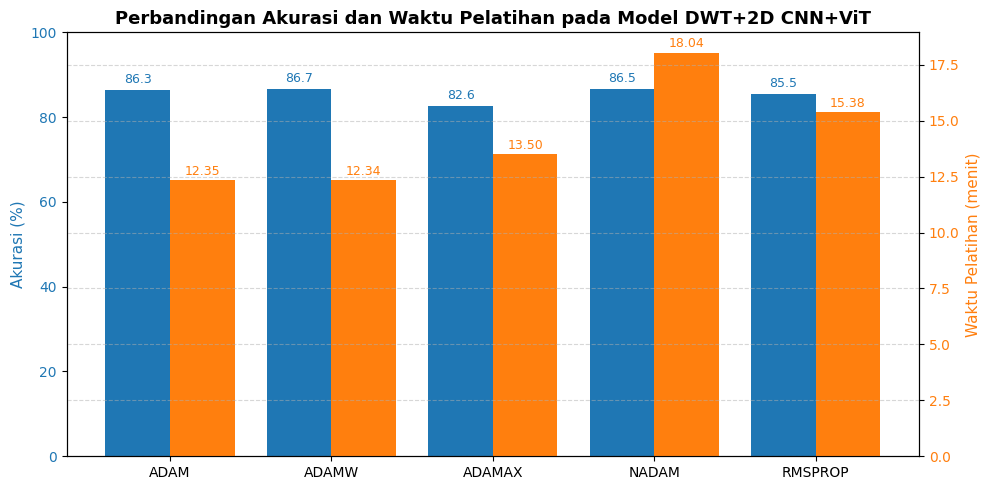

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Optimizer yang mau diuji ===
optimizers_to_test = ["adam", "adamw", "adamax", "nadam", "rmsprop"]
npz_path = "./npz_output/seed_segmentasi5detik_dwt_de.npz"

results = []

# 🚀 Jalankan training untuk semua optimizer
for opt_name in optimizers_to_test:
    print("\n" + "="*60)
    print(f"🔧 Menjalankan optimizer: {opt_name.upper()}")
    try:
        model, total_time, best_acc = train_model_hybrid_simple(
            npz_file=npz_path,
            optimizer_type=opt_name,
            epochs=30,
            batch_size=16,
            lr=1e-4,
            resize=32
        )
        results.append((opt_name.upper(), best_acc * 100, total_time / 60))
    except Exception as e:
        print(f"❌ Error pada optimizer {opt_name.upper()}: {e}")
        results.append((opt_name.upper(), 0, 0))

# === Tampilkan ringkasan hasil ===
df = pd.DataFrame(results, columns=["Optimizer", "Accuracy (%)", "Training Time (min)"])
print("\n📊 RINGKASAN HASIL EKSPERIMEN OPTIMIZER")
print(df.to_string(index=False))

# === Plot hasil ===
fig, ax1 = plt.subplots(figsize=(10,5))
x = np.arange(len(df["Optimizer"]))
bar_width = 0.4

# Bar Akurasi
bars1 = ax1.bar(x - bar_width/2, df["Accuracy (%)"], width=bar_width, color="tab:blue", label="Akurasi (%)")
ax1.set_ylabel("Akurasi (%)", color="tab:blue", fontsize=11)
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(0, 100)

# Tambahkan nilai di atas bar akurasi
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}", ha='center', va='bottom', fontsize=9, color='tab:blue')

# Axis kedua untuk waktu pelatihan
ax2 = ax1.twinx()
bars2 = ax2.bar(x + bar_width/2, df["Training Time (min)"], width=bar_width, color="tab:orange", label="Waktu (menit)")
ax2.set_ylabel("Waktu Pelatihan (menit)", color="tab:orange", fontsize=11)
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Tambahkan nilai di atas bar waktu
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f"{yval:.2f}", ha='center', va='bottom', fontsize=9, color='tab:orange')

# Label dan tampilan umum
plt.title("Perbandingan Akurasi dan Waktu Pelatihan pada Model DWT+2D CNN+ViT", fontsize=13, fontweight="bold")
plt.xticks(x, df["Optimizer"], fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.5)
fig.tight_layout()
plt.show()


In [ ]:
# model_no_dwt = train_model_hybrid_no_dwt("./npz_output/seed_segmentasi5detik_raw.npz")

Epoch 1/30 - loss 1.0790 - acc 0.4282 (best 0.4282)
Epoch 2/30 - loss 1.0419 - acc 0.4739 (best 0.4739)
Epoch 3/30 - loss 1.0165 - acc 0.4535 (best 0.4739)
Epoch 4/30 - loss 1.0026 - acc 0.4865 (best 0.4865)
Epoch 5/30 - loss 0.9920 - acc 0.4879 (best 0.4879)
Epoch 6/30 - loss 0.9830 - acc 0.4987 (best 0.4987)
Epoch 7/30 - loss 0.9742 - acc 0.5019 (best 0.5019)
Epoch 8/30 - loss 0.9630 - acc 0.4961 (best 0.5019)
Epoch 9/30 - loss 0.9531 - acc 0.4909 (best 0.5019)
Epoch 10/30 - loss 0.9432 - acc 0.4849 (best 0.5019)
Epoch 11/30 - loss 0.9335 - acc 0.4977 (best 0.5019)
Epoch 12/30 - loss 0.9199 - acc 0.4853 (best 0.5019)
Epoch 13/30 - loss 0.9068 - acc 0.4987 (best 0.5019)
Epoch 14/30 - loss 0.8905 - acc 0.4833 (best 0.5019)
Epoch 15/30 - loss 0.8741 - acc 0.4871 (best 0.5019)
Epoch 16/30 - loss 0.8562 - acc 0.4959 (best 0.5019)
Epoch 17/30 - loss 0.8292 - acc 0.4925 (best 0.5019)
Epoch 18/30 - loss 0.8091 - acc 0.4925 (best 0.5019)
Epoch 19/30 - loss 0.7866 - acc 0.4865 (best 0.5019)
Ep

In [ ]:
# model_cnn_only = train_cnn_only("./npz_output/seed_segmentasi5detik_dwt_de.npz")


Epoch 1/30 - loss 0.8088 - acc 0.6829 (best 0.6829) - time 59.40s
Epoch 2/30 - loss 0.6765 - acc 0.7219 (best 0.7219) - time 60.77s
Epoch 3/30 - loss 0.6145 - acc 0.7457 (best 0.7457) - time 60.02s
Epoch 4/30 - loss 0.5763 - acc 0.7594 (best 0.7594) - time 59.84s
Epoch 5/30 - loss 0.5413 - acc 0.7668 (best 0.7668) - time 59.72s
Epoch 6/30 - loss 0.5179 - acc 0.7776 (best 0.7776) - time 61.61s
Epoch 7/30 - loss 0.4791 - acc 0.7946 (best 0.7946) - time 62.61s
Epoch 8/30 - loss 0.4620 - acc 0.8082 (best 0.8082) - time 60.84s
Epoch 9/30 - loss 0.4403 - acc 0.8124 (best 0.8124) - time 59.56s
Epoch 10/30 - loss 0.4193 - acc 0.7984 (best 0.8124) - time 59.80s
Epoch 11/30 - loss 0.4070 - acc 0.8156 (best 0.8156) - time 59.85s
Epoch 12/30 - loss 0.3856 - acc 0.8114 (best 0.8156) - time 59.71s
Epoch 13/30 - loss 0.3693 - acc 0.8094 (best 0.8156) - time 60.42s
Epoch 14/30 - loss 0.3504 - acc 0.8150 (best 0.8156) - time 61.93s
Epoch 15/30 - loss 0.3394 - acc 0.8054 (best 0.8156) - time 60.67s
Epoc

In [ ]:
# model_vit_only = train_model_vit_only(
#     "./npz_output/seed_segmentasi5detik_dwt_de.npz",
#     epochs=30, batch_size=16, lr=1e-4
# )


Epoch 1/30 - loss 0.9205 - acc 0.6146 (best 0.6146)
Epoch 2/30 - loss 0.7752 - acc 0.6635 (best 0.6635)
Epoch 3/30 - loss 0.7211 - acc 0.6657 (best 0.6657)
Epoch 4/30 - loss 0.6883 - acc 0.6949 (best 0.6949)
Epoch 5/30 - loss 0.6708 - acc 0.7009 (best 0.7009)
Epoch 6/30 - loss 0.6533 - acc 0.7001 (best 0.7009)
Epoch 7/30 - loss 0.6429 - acc 0.7193 (best 0.7193)
Epoch 8/30 - loss 0.6297 - acc 0.7049 (best 0.7193)
Epoch 9/30 - loss 0.6163 - acc 0.7243 (best 0.7243)
Epoch 10/30 - loss 0.6099 - acc 0.7171 (best 0.7243)
Epoch 11/30 - loss 0.5970 - acc 0.7239 (best 0.7243)
Epoch 12/30 - loss 0.5906 - acc 0.7303 (best 0.7303)
Epoch 13/30 - loss 0.5846 - acc 0.7329 (best 0.7329)
Epoch 14/30 - loss 0.5769 - acc 0.7423 (best 0.7423)
Epoch 15/30 - loss 0.5688 - acc 0.7381 (best 0.7423)
Epoch 16/30 - loss 0.5603 - acc 0.7391 (best 0.7423)
Epoch 17/30 - loss 0.5548 - acc 0.7475 (best 0.7475)
Epoch 18/30 - loss 0.5480 - acc 0.7562 (best 0.7562)
Epoch 19/30 - loss 0.5394 - acc 0.7604 (best 0.7604)
Ep

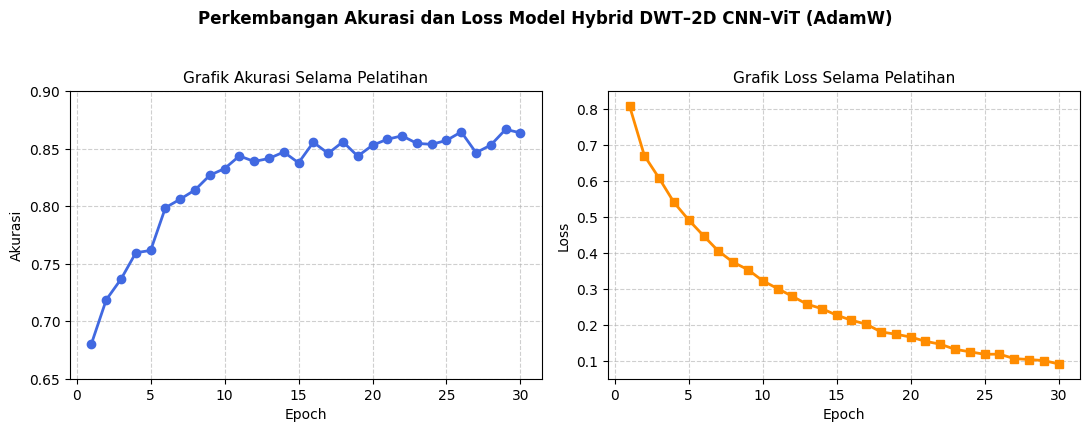

In [ ]:
import matplotlib.pyplot as plt

# Data hasil training (AdamW)
epochs = list(range(1, 31))
accuracy = [
    0.6805, 0.7187, 0.7367, 0.7596, 0.7616, 0.7988, 0.8062, 0.8142, 0.8270, 0.8328,
    0.8438, 0.8390, 0.8416, 0.8472, 0.8378, 0.8557, 0.8460, 0.8561, 0.8436, 0.8531,
    0.8583, 0.8613, 0.8547, 0.8539, 0.8573, 0.8647, 0.8466, 0.8533, 0.8669, 0.8639
]
loss = [
    0.8087, 0.6708, 0.6079, 0.5408, 0.4916, 0.4480, 0.4053, 0.3743, 0.3536, 0.3226,
    0.3011, 0.2794, 0.2574, 0.2450, 0.2269, 0.2128, 0.2018, 0.1803, 0.1739, 0.1661,
    0.1541, 0.1462, 0.1319, 0.1250, 0.1180, 0.1184, 0.1061, 0.1034, 0.1006, 0.0912
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4.5))

# Subplot kiri – Akurasi
ax1.plot(epochs, accuracy, color='royalblue', marker='o', linewidth=2)
ax1.set_title('Grafik Akurasi Selama Pelatihan', fontsize=11)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Akurasi')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_ylim(0.65, 0.90)

# Subplot kanan – Loss
ax2.plot(epochs, loss, color='darkorange', marker='s', linewidth=2)
ax2.set_title('Grafik Loss Selama Pelatihan', fontsize=11)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_ylim(0.05, 0.85)

# Tata letak dan simpan gambar
plt.suptitle('Perkembangan Akurasi dan Loss Model Hybrid DWT–2D CNN–ViT (AdamW)', fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("grafik_dua_subplot_adamw.png", dpi=300)
plt.show()


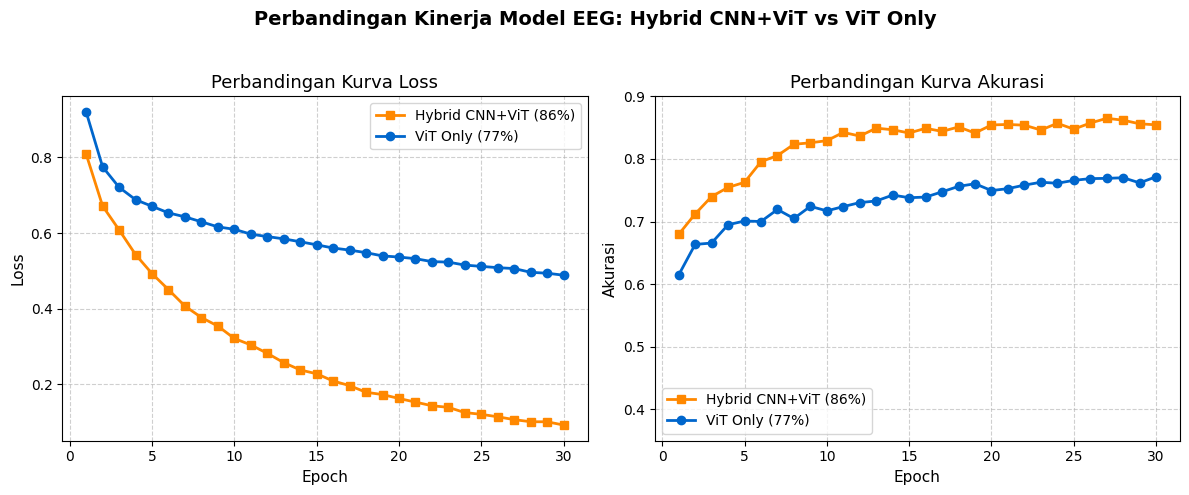

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ============================
# DATA TRAINING
# ============================

# --- ViT Only (77%) ---
vit_loss = [0.9205, 0.7752, 0.7211, 0.6883, 0.6708, 0.6533, 0.6429, 0.6297, 0.6163, 0.6099,
            0.5970, 0.5906, 0.5846, 0.5769, 0.5688, 0.5603, 0.5548, 0.5480, 0.5394, 0.5364,
            0.5321, 0.5243, 0.5230, 0.5151, 0.5117, 0.5083, 0.5059, 0.4960, 0.4936, 0.4883]
vit_acc = [0.6146, 0.6635, 0.6657, 0.6949, 0.7009, 0.7001, 0.7193, 0.7049, 0.7243, 0.7171,
           0.7239, 0.7303, 0.7329, 0.7423, 0.7381, 0.7391, 0.7475, 0.7562, 0.7604, 0.7495,
           0.7526, 0.7582, 0.7628, 0.7612, 0.7658, 0.7686, 0.7690, 0.7700, 0.7618, 0.7716]

# --- Hybrid CNN+ViT (86%) ---
hybrid_loss = [0.8090, 0.6715, 0.6084, 0.5430, 0.4926, 0.4501, 0.4066, 0.3763, 0.3536, 0.3208,
               0.3037, 0.2815, 0.2569, 0.2375, 0.2273, 0.2082, 0.1960, 0.1783, 0.1723, 0.1619,
               0.1523, 0.1427, 0.1384, 0.1246, 0.1199, 0.1134, 0.1059, 0.1003, 0.1002, 0.0915]
hybrid_acc = [0.6795, 0.7121, 0.7399, 0.7546, 0.7626, 0.7956, 0.8054, 0.8234, 0.8258, 0.8292,
              0.8424, 0.8366, 0.8492, 0.8466, 0.8414, 0.8490, 0.8440, 0.8511, 0.8414, 0.8543,
              0.8551, 0.8539, 0.8462, 0.8569, 0.8476, 0.8573, 0.8649, 0.8619, 0.8561, 0.8545]

epochs = np.arange(1, 31)

# ============================
# GRAFIK DENGAN TITIK-TITIK
# ============================

plt.figure(figsize=(12,5))

# --- LOSS ---
plt.subplot(1,2,1)
plt.plot(epochs, hybrid_loss, marker='s', color='#FF8800', linewidth=2, label='Hybrid CNN+ViT (86%)')
plt.plot(epochs, vit_loss, marker='o', color='#0066CC', linewidth=2, label='ViT Only (77%)')
plt.title("Perbandingan Kurva Loss", fontsize=13)
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Loss", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# --- AKURASI ---
plt.subplot(1,2,2)
plt.plot(epochs, hybrid_acc, marker='s', color='#FF8800', linewidth=2, label='Hybrid CNN+ViT (86%)')
plt.plot(epochs, vit_acc, marker='o', color='#0066CC', linewidth=2, label='ViT Only (77%)')
plt.title("Perbandingan Kurva Akurasi", fontsize=13)
plt.xlabel("Epoch", fontsize=11)
plt.ylabel("Akurasi", fontsize=11)
plt.ylim(0.35, 0.9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

# --- Judul Utama ---
plt.suptitle("Perbandingan Kinerja Model EEG: Hybrid CNN+ViT vs ViT Only", 
             fontsize=14, fontweight="bold")

plt.tight_layout(rect=[0,0,1,0.95])
plt.show() 

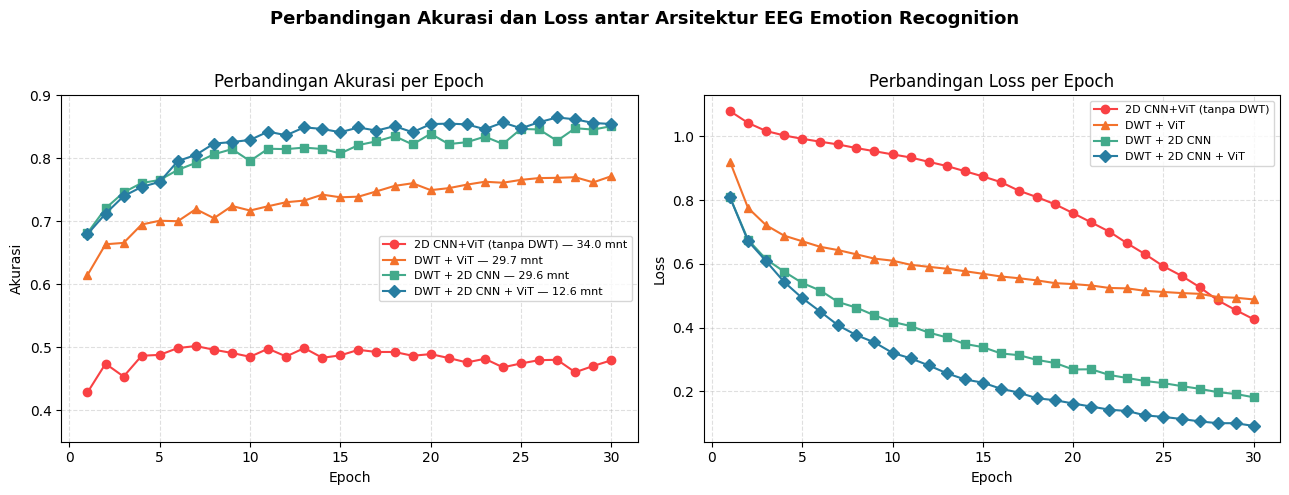


Ringkasan Waktu Total Pelatihan:
- 2D CNN+ViT (tanpa DWT): 34.02 menit (~2041 detik)
- DWT + ViT: 29.70 menit (~1782 detik)
- DWT + 2D CNN: 29.65 menit (~1779 detik)
- DWT + 2D CNN + ViT: 12.56 menit (~754 detik)


In [14]:
import matplotlib.pyplot as plt
import numpy as np

# ============================
# HASIL TRAINING (revan’s data)
# ============================

# 1) 2D CNN+ViT TANPA DWT
acc_hybrid_no_dwt = [0.4282,0.4739,0.4535,0.4865,0.4879,0.4987,0.5019,0.4961,0.4909,0.4849,
                     0.4977,0.4853,0.4987,0.4833,0.4871,0.4959,0.4925,0.4925,0.4865,0.4891,
                     0.4829,0.4759,0.4817,0.4681,0.4743,0.4795,0.4801,0.4603,0.4703,0.4793]
loss_hybrid_no_dwt = [1.0790,1.0419,1.0165,1.0026,0.9920,0.9830,0.9742,0.9630,0.9531,0.9432,
                      0.9335,0.9199,0.9068,0.8905,0.8741,0.8562,0.8292,0.8091,0.7866,0.7588,
                      0.7299,0.7009,0.6639,0.6296,0.5922,0.5624,0.5269,0.4857,0.4548,0.4261]
time_hybrid_no_dwt_min = 34.02

# 2) DWT + 2D CNN
acc_cnn_dwt = [0.6813,0.7205,0.7459,0.7608,0.7656,0.7816,0.7928,0.8064,0.8146,0.7958,
               0.8152,0.8146,0.8170,0.8148,0.8078,0.8210,0.8270,0.8352,0.8220,0.8390,
               0.8226,0.8256,0.8344,0.8228,0.8466,0.8458,0.8278,0.8478,0.8456,0.8511]
loss_cnn_dwt = [0.8085,0.6757,0.6143,0.5754,0.5400,0.5163,0.4800,0.4626,0.4384,0.4179,
                0.4049,0.3845,0.3693,0.3489,0.3388,0.3190,0.3135,0.2986,0.2890,0.2687,
                0.2693,0.2515,0.2418,0.2324,0.2258,0.2166,0.2081,0.1975,0.1919,0.1814]
time_cnn_dwt_min = 29.65

# 3) DWT + ViT
acc_vit_dwt = [0.6146,0.6635,0.6657,0.6949,0.7009,0.7001,0.7193,0.7049,0.7243,0.7171,
               0.7239,0.7303,0.7329,0.7423,0.7381,0.7391,0.7475,0.7562,0.7604,0.7495,
               0.7526,0.7582,0.7628,0.7612,0.7658,0.7686,0.7690,0.7700,0.7618,0.7716]
loss_vit_dwt = [0.9205,0.7752,0.7211,0.6883,0.6708,0.6533,0.6429,0.6297,0.6163,0.6099,
                0.5970,0.5906,0.5846,0.5769,0.5688,0.5603,0.5548,0.5480,0.5394,0.5364,
                0.5321,0.5243,0.5230,0.5151,0.5117,0.5083,0.5059,0.4960,0.4936,0.4883]
time_vit_dwt_min = 29.70

# 4) DWT + 2D CNN + ViT
acc_hybrid_dwt = [0.6795,0.7121,0.7399,0.7546,0.7626,0.7956,0.8054,0.8234,0.8258,0.8292,
                  0.8424,0.8366,0.8492,0.8466,0.8414,0.8490,0.8440,0.8511,0.8414,0.8543,
                  0.8551,0.8539,0.8462,0.8569,0.8476,0.8573,0.8649,0.8619,0.8561,0.8545]
loss_hybrid_dwt = [0.8090,0.6715,0.6084,0.5430,0.4926,0.4501,0.4066,0.3763,0.3536,0.3208,
                   0.3037,0.2815,0.2569,0.2375,0.2273,0.2082,0.1960,0.1783,0.1723,0.1619,
                   0.1523,0.1427,0.1384,0.1246,0.1199,0.1134,0.1059,0.1003,0.1002,0.0915]
time_hybrid_dwt_min = 12.56

# ============================
# VISUALISASI GABUNGAN
# ============================

epochs = np.arange(1, 31)
colors = ['#F94144','#F3722C','#43AA8B','#277DA1']  # palet warna rapi

plt.figure(figsize=(13,5))

# --- Akurasi ---
ax1 = plt.subplot(1,2,1)
ax1.plot(epochs, acc_hybrid_no_dwt, marker='o', color=colors[0], label=f'2D CNN+ViT (tanpa DWT) — {time_hybrid_no_dwt_min:.1f} mnt')
ax1.plot(epochs, acc_vit_dwt,      marker='^', color=colors[1], label=f'DWT + ViT — {time_vit_dwt_min:.1f} mnt')
ax1.plot(epochs, acc_cnn_dwt,      marker='s', color=colors[2], label=f'DWT + 2D CNN — {time_cnn_dwt_min:.1f} mnt')
ax1.plot(epochs, acc_hybrid_dwt,   marker='D', color=colors[3], label=f'DWT + 2D CNN + ViT — {time_hybrid_dwt_min:.1f} mnt')
ax1.set_title('Perbandingan Akurasi per Epoch')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Akurasi')
ax1.set_ylim(0.35, 0.90)
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(fontsize=8)

# --- Loss ---
ax2 = plt.subplot(1,2,2)
ax2.plot(epochs, loss_hybrid_no_dwt, marker='o', color=colors[0], label='2D CNN+ViT (tanpa DWT)')
ax2.plot(epochs, loss_vit_dwt,      marker='^', color=colors[1], label='DWT + ViT')
ax2.plot(epochs, loss_cnn_dwt,      marker='s', color=colors[2], label='DWT + 2D CNN')
ax2.plot(epochs, loss_hybrid_dwt,   marker='D', color=colors[3], label='DWT + 2D CNN + ViT')
ax2.set_title('Perbandingan Loss per Epoch')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend(fontsize=8)

plt.suptitle('Perbandingan Akurasi dan Loss antar Arsitektur EEG Emotion Recognition', fontsize=13, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ============================
# CETAK RINGKASAN WAKTU
# ============================

def fmt_time(name, minutes):
    if minutes is None:
        return f"- {name}: (belum diukur)"
    return f"- {name}: {minutes:.2f} menit (~{minutes*60:.0f} detik)"

print("\nRingkasan Waktu Total Pelatihan:")
print(fmt_time("2D CNN+ViT (tanpa DWT)", time_hybrid_no_dwt_min))
print(fmt_time("DWT + ViT", time_vit_dwt_min))
print(fmt_time("DWT + 2D CNN", time_cnn_dwt_min))
print(fmt_time("DWT + 2D CNN + ViT", time_hybrid_dwt_min))


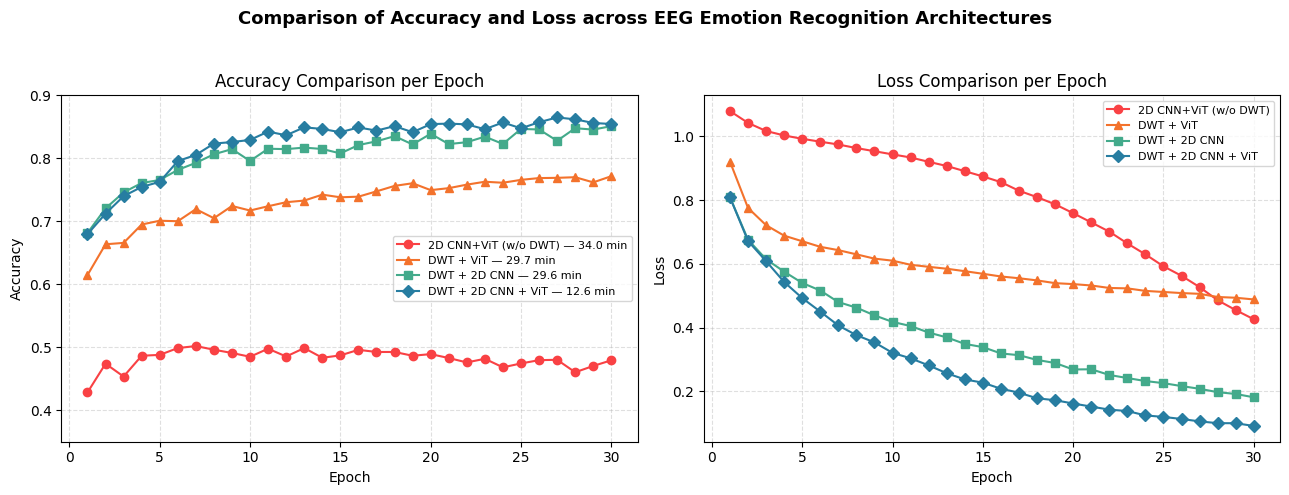


Total Training Time Summary:
- 2D CNN+ViT (w/o DWT): 34.02 minutes (~2041 seconds)
- DWT + ViT: 29.70 minutes (~1782 seconds)
- DWT + 2D CNN: 29.65 minutes (~1779 seconds)
- DWT + 2D CNN + ViT: 12.56 minutes (~754 seconds)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ============================
# TRAINING RESULTS (Revan’s data)
# ============================

# 1) 2D CNN+ViT WITHOUT DWT
acc_hybrid_no_dwt = [0.4282,0.4739,0.4535,0.4865,0.4879,0.4987,0.5019,0.4961,0.4909,0.4849,
                     0.4977,0.4853,0.4987,0.4833,0.4871,0.4959,0.4925,0.4925,0.4865,0.4891,
                     0.4829,0.4759,0.4817,0.4681,0.4743,0.4795,0.4801,0.4603,0.4703,0.4793]
loss_hybrid_no_dwt = [1.0790,1.0419,1.0165,1.0026,0.9920,0.9830,0.9742,0.9630,0.9531,0.9432,
                      0.9335,0.9199,0.9068,0.8905,0.8741,0.8562,0.8292,0.8091,0.7866,0.7588,
                      0.7299,0.7009,0.6639,0.6296,0.5922,0.5624,0.5269,0.4857,0.4548,0.4261]
time_hybrid_no_dwt_min = 34.02

# 2) DWT + 2D CNN
acc_cnn_dwt = [0.6813,0.7205,0.7459,0.7608,0.7656,0.7816,0.7928,0.8064,0.8146,0.7958,
               0.8152,0.8146,0.8170,0.8148,0.8078,0.8210,0.8270,0.8352,0.8220,0.8390,
               0.8226,0.8256,0.8344,0.8228,0.8466,0.8458,0.8278,0.8478,0.8456,0.8511]
loss_cnn_dwt = [0.8085,0.6757,0.6143,0.5754,0.5400,0.5163,0.4800,0.4626,0.4384,0.4179,
                0.4049,0.3845,0.3693,0.3489,0.3388,0.3190,0.3135,0.2986,0.2890,0.2687,
                0.2693,0.2515,0.2418,0.2324,0.2258,0.2166,0.2081,0.1975,0.1919,0.1814]
time_cnn_dwt_min = 29.65

# 3) DWT + ViT
acc_vit_dwt = [0.6146,0.6635,0.6657,0.6949,0.7009,0.7001,0.7193,0.7049,0.7243,0.7171,
               0.7239,0.7303,0.7329,0.7423,0.7381,0.7391,0.7475,0.7562,0.7604,0.7495,
               0.7526,0.7582,0.7628,0.7612,0.7658,0.7686,0.7690,0.7700,0.7618,0.7716]
loss_vit_dwt = [0.9205,0.7752,0.7211,0.6883,0.6708,0.6533,0.6429,0.6297,0.6163,0.6099,
                0.5970,0.5906,0.5846,0.5769,0.5688,0.5603,0.5548,0.5480,0.5394,0.5364,
                0.5321,0.5243,0.5230,0.5151,0.5117,0.5083,0.5059,0.4960,0.4936,0.4883]
time_vit_dwt_min = 29.70

# 4) DWT + 2D CNN + ViT
acc_hybrid_dwt = [0.6795,0.7121,0.7399,0.7546,0.7626,0.7956,0.8054,0.8234,0.8258,0.8292,
                  0.8424,0.8366,0.8492,0.8466,0.8414,0.8490,0.8440,0.8511,0.8414,0.8543,
                  0.8551,0.8539,0.8462,0.8569,0.8476,0.8573,0.8649,0.8619,0.8561,0.8545]
loss_hybrid_dwt = [0.8090,0.6715,0.6084,0.5430,0.4926,0.4501,0.4066,0.3763,0.3536,0.3208,
                   0.3037,0.2815,0.2569,0.2375,0.2273,0.2082,0.1960,0.1783,0.1723,0.1619,
                   0.1523,0.1427,0.1384,0.1246,0.1199,0.1134,0.1059,0.1003,0.1002,0.0915]
time_hybrid_dwt_min = 12.56

# ============================
# COMBINED VISUALIZATION
# ============================

epochs = np.arange(1, 31)
colors = ['#F94144','#F3722C','#43AA8B','#277DA1']

plt.figure(figsize=(13,5))

# --- Accuracy Plot ---
ax1 = plt.subplot(1,2,1)
# Note: "w/o" stands for "without", standard in charts
ax1.plot(epochs, acc_hybrid_no_dwt, marker='o', color=colors[0], label=f'2D CNN+ViT (w/o DWT) — {time_hybrid_no_dwt_min:.1f} min')
ax1.plot(epochs, acc_vit_dwt,      marker='^', color=colors[1], label=f'DWT + ViT — {time_vit_dwt_min:.1f} min')
ax1.plot(epochs, acc_cnn_dwt,      marker='s', color=colors[2], label=f'DWT + 2D CNN — {time_cnn_dwt_min:.1f} min')
ax1.plot(epochs, acc_hybrid_dwt,   marker='D', color=colors[3], label=f'DWT + 2D CNN + ViT — {time_hybrid_dwt_min:.1f} min')

ax1.set_title('Accuracy Comparison per Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.35, 0.90)
ax1.grid(True, linestyle='--', alpha=0.4)
ax1.legend(fontsize=8)

# --- Loss Plot ---
ax2 = plt.subplot(1,2,2)
ax2.plot(epochs, loss_hybrid_no_dwt, marker='o', color=colors[0], label='2D CNN+ViT (w/o DWT)')
ax2.plot(epochs, loss_vit_dwt,      marker='^', color=colors[1], label='DWT + ViT')
ax2.plot(epochs, loss_cnn_dwt,      marker='s', color=colors[2], label='DWT + 2D CNN')
ax2.plot(epochs, loss_hybrid_dwt,   marker='D', color=colors[3], label='DWT + 2D CNN + ViT')

ax2.set_title('Loss Comparison per Epoch')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend(fontsize=8)

# Main Title
plt.suptitle('Comparison of Accuracy and Loss across EEG Emotion Recognition Architectures', fontsize=13, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# ============================
# PRINT TIME SUMMARY
# ============================

def fmt_time(name, minutes):
    if minutes is None:
        return f"- {name}: (not measured)"
    return f"- {name}: {minutes:.2f} minutes (~{minutes*60:.0f} seconds)"

print("\nTotal Training Time Summary:")
print(fmt_time("2D CNN+ViT (w/o DWT)", time_hybrid_no_dwt_min))
print(fmt_time("DWT + ViT", time_vit_dwt_min))
print(fmt_time("DWT + 2D CNN", time_cnn_dwt_min))
print(fmt_time("DWT + 2D CNN + ViT", time_hybrid_dwt_min))

Uji

In [4]:
FS = 128           # Hz
WIN_SEC = 5        # detik per segmen
TARGET_CHANNELS = ["FT7","FT8","T7","C5","C6","T8",
                   "TP7","CP5","CP6","TP8","P7","P8"]

# Mapping kanal SEED -> kanal Emotiv
CHANNEL_MAP = {
    "FT7": "EEG.F7",
    "FT8": "EEG.F8",
    "T7":  "EEG.T7",
    "C5":  "EEG.FC5",
    "C6":  "EEG.FC6",
    "T8":  "EEG.T8",
    "TP7": "EEG.P7",
    "CP5": "EEG.P7",  # pendekatan
    "CP6": "EEG.P8",
    "TP8": "EEG.P8",
    "P7":  "EEG.P7",
    "P8":  "EEG.P8",
}

In [5]:
seed_stats = np.load("./npz_output/seed_segmentasi5detik_dwt_de.npz")
MEAN = seed_stats["X"].mean(axis=0)
STD  = seed_stats["X"].std(axis=0) + 1e-6
print("Mean & Std training SEED berhasil dimuat ✅")


Mean & Std training SEED berhasil dimuat ✅


In [6]:
def extract_dwt_de(data, wavelet="db4", level=5):
    """
    data shape: (n_channels, n_samples)
    output: (n_bands=5, n_channels)
    """
    feats = []
    for ch_signal in data:
        coeffs = pywt.wavedec(ch_signal, wavelet, level=level)
        de = [np.log(np.var(c) + 1e-8) for c in coeffs[1:6][::-1]]  # D5–D1 = delta..gamma
        feats.append(de)
    return np.array(feats).T


In [13]:
def load_emotiv_mapped(csv_path, channel_map):
    df = pd.read_csv(csv_path, skiprows=1)
    df.columns = [c.strip() for c in df.columns]

    data = []
    for target_ch, source_ch in channel_map.items():
        if source_ch in df.columns:
            x = pd.to_numeric(df[source_ch], errors="coerce").fillna(method="ffill").fillna(method="bfill")
        else:
            x = pd.Series(np.zeros(len(df)))
        data.append(x.values)
    data = np.array(data)
    data = data - np.mean(data, axis=1, keepdims=True)
    return data, list(channel_map.keys())  


/tmp/ipykernel_7472/211153825.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = pd.to_numeric(df[source_ch], errors="coerce").fillna(method="ffill").fillna(method="bfill")


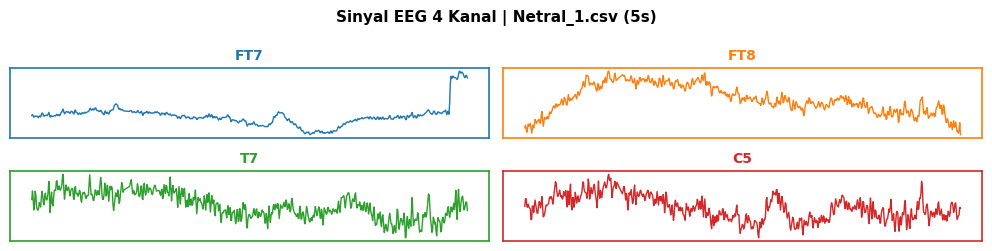

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_4_single_colored(csv_path, channels=["FT7", "FT8", "T7", "C5"], start_sec=0, dur_sec=5):
    data, ch_names = load_emotiv_mapped(csv_path, CHANNEL_MAP)
    fs = FS
    start = int(start_sec * fs)
    end = int((start_sec + dur_sec) * fs)
    t = np.arange(start, end) / fs

    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]  # 🎨 warna beda tiap kanal
    fig, axes = plt.subplots(2, 2, figsize=(10, 2.5))
    axes = axes.flatten()

    for i, ch in enumerate(channels):
        idx = ch_names.index(ch)
        axes[i].plot(t, data[idx, start:end], color=colors[i], linewidth=1.0)
        axes[i].set_title(ch, fontsize=10, color=colors[i], fontweight="bold")
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        # buat kotak rapi
        for spine in axes[i].spines.values():
            spine.set_visible(True)
            spine.set_color(colors[i])
            spine.set_linewidth(1.2)

    plt.suptitle(f"Sinyal EEG 4 Kanal | {os.path.basename(csv_path)} ({dur_sec}s)", fontsize=11, fontweight="semibold")
    plt.tight_layout(pad=1.0)
    plt.show()

# Contoh pemakaian
csv_path = "/home/revan/PKM/Emosi Revan/Netral/Netral_1.csv"
plot_4_single_colored(csv_path)

In [35]:
def preprocess_realtime(csv_path, out_dir="./realtime_features"):
    os.makedirs(out_dir, exist_ok=True)
    data = load_emotiv_mapped(csv_path, CHANNEL_MAP)
    n_samples = data.shape[1]
    win = FS * WIN_SEC
    n_seg = n_samples // win

    feats_all = []
    for i in range(n_seg):
        seg = data[:, i*win:(i+1)*win]
        feats = extract_dwt_de(seg)

        # --- otomatis pilih orientasi normalisasi ---
        if feats.shape == MEAN.shape:
            feats = (feats - MEAN) / STD
        elif feats.shape == MEAN.T.shape:
            feats = (feats - MEAN.T) / STD.T
        else:
            print(f"⚠️ Shape tidak cocok, dilewati: feats={feats.shape}, mean={MEAN.shape}")
            continue

        feats_all.append(feats)

    if len(feats_all) == 0:
        raise ValueError("Tidak ada segmen valid yang berhasil diproses!")

    feats_all = np.stack(feats_all)
    out_path = os.path.join(out_dir, os.path.basename(csv_path).replace(".csv", "_preprocessed.npz"))
    np.savez_compressed(out_path, X=feats_all)
    print(f"[OK] {csv_path} → {out_path} | total segmen: {len(feats_all)}")
    return out_path


In [67]:
csv_path = "/home/revan/PKM/Emosi Revan/Netral/Netral_2.csv" # atau Netral_2.csv
out_path = preprocess_realtime(csv_path)


Loaded: /home/revan/PKM/Emosi Revan/Netral/Netral_2.csv | shape = (12, 30900)
[OK] /home/revan/PKM/Emosi Revan/Netral/Netral_2.csv → ./realtime_features/Netral_2_preprocessed.npz | total segmen: 48


/tmp/ipykernel_883/495047999.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = pd.to_numeric(df[source_ch], errors="coerce").fillna(method="ffill").fillna(method="bfill")


In [68]:
data = np.load(out_path)
print("Keys:", list(data.keys()))
print("Shape X:", data["X"].shape)


Keys: ['X']
Shape X: (48, 12, 5)


In [15]:
# Simpan bobot model
torch.save(model_hybrid_simple.state_dict(), "hybrid_cnn_vit_seed.pth")
print("Model disimpan sebagai hybrid_cnn_vit_seed.pth")


Model disimpan sebagai hybrid_cnn_vit_seed.pth


In [69]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

model = HybridCNNViT_SimplePE(
    in_channels=5, 
    emb_dim=128, 
    num_heads=2, 
    num_layers=1, 
    num_classes=3
)
model.load_state_dict(torch.load("hybrid_cnn_vit_seed.pth", map_location=device))
model.to(device).eval()

label_map = {0: "Negatif", 1: "Netral", 2: "Positif"}
print("✅ Model siap di", device)

✅ Model siap di cuda


/tmp/ipykernel_883/3142237468.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hybrid_cnn_vit_seed.pth", map_location=device))


In [70]:
from scipy.interpolate import griddata
import numpy as np

CHANNEL_POS = {
    "FT7": (-0.6, 0.5), "FT8": (0.6, 0.5),
    "T7":  (-0.8, 0.0), "C5":  (-0.4, 0.0), "C6": (0.4, 0.0), "T8": (0.8, 0.0),
    "TP7": (-0.6, -0.4), "CP5": (-0.3, -0.4), "CP6": (0.3, -0.4), "TP8": (0.6, -0.4),
    "P7": (-0.5, -0.7), "P8": (0.5, -0.7),
}

def eeg_to_topomap_image(feats, grid_res=32):
    """
    feats: (5 bands, 12 channels) atau (12, 5)
    output: (5, grid_res, grid_res)
    """
    # pastikan orientasi (5 bands × 12 channel)
    if feats.shape[0] == 12 and feats.shape[1] == 5:
        feats = feats.T  # balik jadi (5, 12)

    xs, ys = np.mgrid[-1:1:complex(grid_res), -1:1:complex(grid_res)]
    img = np.zeros((5, grid_res, grid_res))
    points = np.array(list(CHANNEL_POS.values()))  # 12 titik

    for i in range(5):
        vals = feats[i, :]  # 12 nilai sesuai jumlah titik
        img[i] = griddata(points, vals, (xs, ys), method='cubic', fill_value=np.nan)
        img[i] = np.nan_to_num(img[i])
    return img



In [75]:
def predict_realtime_segments(model, npz_path, device="cuda"):
    data = np.load(npz_path)["X"]  # (n_seg, 5, 12)
    preds = []

    for i, feats in enumerate(data):
        img = eeg_to_topomap_image(feats, grid_res=32)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(img).argmax(1).item()
        preds.append(pred)
        print(f"Segmen {i+1:02d}: {label_map[pred]}")

    majority = max(set(preds), key=preds.count)
    print("\n🧭 Mayoritas emosi:", label_map[majority])
    return preds

# Jalankan prediksi
npz_path = "./realtime_features/Sedih_2_preprocessed.npz"
preds = predict_realtime_segments(model, npz_path, device=device)


Segmen 01: Netral
Segmen 02: Netral
Segmen 03: Negatif
Segmen 04: Netral
Segmen 05: Negatif
Segmen 06: Negatif
Segmen 07: Netral
Segmen 08: Negatif
Segmen 09: Netral
Segmen 10: Netral
Segmen 11: Netral
Segmen 12: Netral
Segmen 13: Netral
Segmen 14: Netral
Segmen 15: Netral
Segmen 16: Negatif
Segmen 17: Netral
Segmen 18: Negatif
Segmen 19: Negatif
Segmen 20: Netral
Segmen 21: Netral
Segmen 22: Netral
Segmen 23: Netral
Segmen 24: Negatif
Segmen 25: Netral
Segmen 26: Netral
Segmen 27: Netral
Segmen 28: Netral
Segmen 29: Negatif
Segmen 30: Negatif
Segmen 31: Netral
Segmen 32: Netral
Segmen 33: Negatif
Segmen 34: Negatif
Segmen 35: Negatif
Segmen 36: Netral
Segmen 37: Negatif
Segmen 38: Negatif
Segmen 39: Negatif
Segmen 40: Netral
Segmen 41: Negatif
Segmen 42: Netral
Segmen 43: Netral
Segmen 44: Negatif
Segmen 45: Negatif
Segmen 46: Netral
Segmen 47: Negatif
Segmen 48: Netral

🧭 Mayoritas emosi: Netral


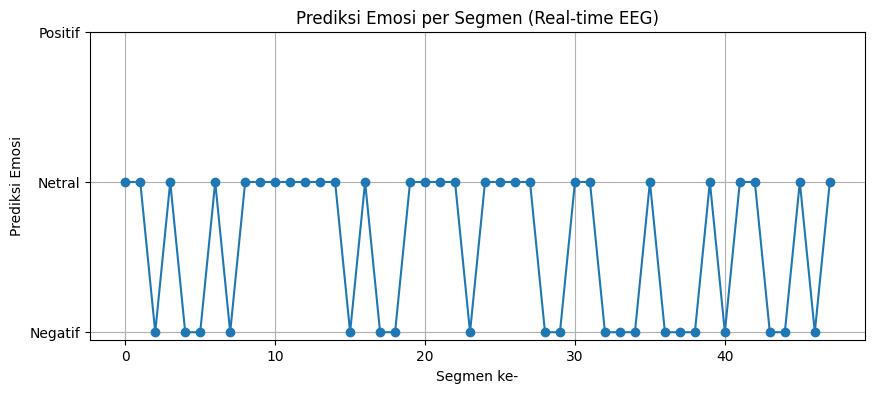

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(preds, marker='o')
plt.yticks([0,1,2], ["Negatif", "Netral", "Positif"])
plt.xlabel("Segmen ke-")
plt.ylabel("Prediksi Emosi")
plt.title("Prediksi Emosi per Segmen (Real-time EEG)")
plt.grid(True)
plt.show()


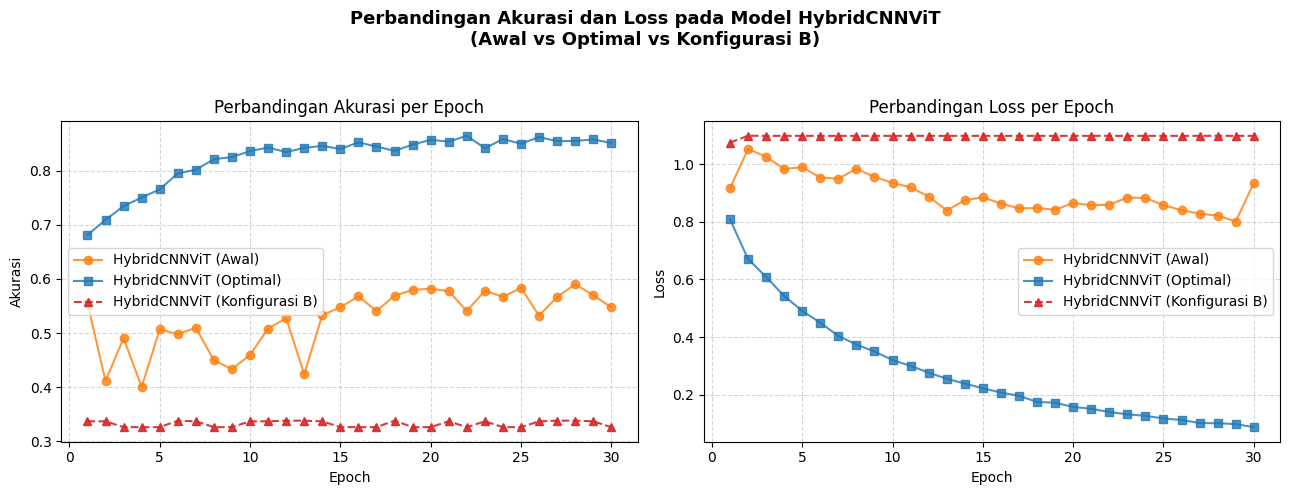

In [3]:
import matplotlib.pyplot as plt

# === Data ===
epochs = list(range(1, 31))

# HybridCNNViT (Awal)
loss_awal = [
    0.9162, 1.0530, 1.0264, 0.9835, 0.9901,
    0.9536, 0.9502, 0.9842, 0.9560, 0.9355,
    0.9199, 0.8880, 0.8394, 0.8752, 0.8853,
    0.8637, 0.8468, 0.8487, 0.8419, 0.8654,
    0.8573, 0.8598, 0.8845, 0.8831, 0.8580,
    0.8406, 0.8284, 0.8217, 0.8013, 0.9352
]
acc_awal = [
    0.5552, 0.4116, 0.4903, 0.4002, 0.5067,
    0.4979, 0.5097, 0.4496, 0.4332, 0.4595,
    0.5083, 0.5273, 0.4236, 0.5331, 0.5477,
    0.5678, 0.5409, 0.5690, 0.5798, 0.5820,
    0.5774, 0.5409, 0.5782, 0.5670, 0.5834,
    0.5323, 0.5666, 0.5902, 0.5700, 0.5477
]

# HybridCNNViT (Optimal)
loss_opt = [
    0.8090, 0.6713, 0.6088, 0.5427, 0.4912,
    0.4498, 0.4041, 0.3739, 0.3500, 0.3202,
    0.3000, 0.2766, 0.2554, 0.2384, 0.2224,
    0.2073, 0.1963, 0.1748, 0.1722, 0.1575,
    0.1511, 0.1399, 0.1317, 0.1267, 0.1173,
    0.1123, 0.1015, 0.1009, 0.0978, 0.0873
]
acc_opt = [
    0.6815, 0.7095, 0.7351, 0.7508, 0.7660,
    0.7956, 0.8024, 0.8218, 0.8258, 0.8368,
    0.8434, 0.8350, 0.8428, 0.8464, 0.8408,
    0.8529, 0.8452, 0.8372, 0.8488, 0.8577,
    0.8543, 0.8653, 0.8420, 0.8591, 0.8503,
    0.8629, 0.8551, 0.8557, 0.8583, 0.8519
]

# HybridCNNViT (Konfigurasi B)
loss_baru = [1.0752,1.0992,1.0986,1.0988,1.0987,1.0987,1.0987,1.0988,1.0987,1.0987,
             1.0987,1.0987,1.0987,1.0987,1.0987,1.0987,1.0987,1.0987,1.0986,1.0988,
             1.0987,1.0988,1.0986,1.0988,1.0987,1.0987,1.0988,1.0988,1.0988,1.0987]
acc_baru  = [0.3365,0.3365,0.3257,0.3257,0.3257,0.3377,0.3365,0.3257,0.3257,0.3365,
             0.3365,0.3377,0.3377,0.3365,0.3257,0.3257,0.3257,0.3377,0.3257,0.3257,
             0.3365,0.3257,0.3365,0.3257,0.3257,0.3365,0.3377,0.3377,0.3365,0.3257]

# === Plot Side-by-Side ===
plt.figure(figsize=(13,5))

# --- Akurasi ---
ax1 = plt.subplot(1,2,1)
ax1.plot(epochs, acc_awal, label="HybridCNNViT (Awal)", marker='o', color='tab:orange', alpha=0.8)
ax1.plot(epochs, acc_opt, label="HybridCNNViT (Optimal)", marker='s', color='tab:blue', alpha=0.8)
ax1.plot(epochs, acc_baru, label="HybridCNNViT (Konfigurasi B)", marker='^', linestyle='--', color='tab:red', alpha=0.9)
ax1.set_title("Perbandingan Akurasi per Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Akurasi")
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()

# --- Loss ---
ax2 = plt.subplot(1,2,2)
ax2.plot(epochs, loss_awal, label="HybridCNNViT (Awal)", marker='o', color='tab:orange', alpha=0.8)
ax2.plot(epochs, loss_opt, label="HybridCNNViT (Optimal)", marker='s', color='tab:blue', alpha=0.8)
ax2.plot(epochs, loss_baru, label="HybridCNNViT (Konfigurasi B)", marker='^', linestyle='--', color='tab:red', alpha=0.9)
ax2.set_title("Perbandingan Loss per Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

plt.suptitle("Perbandingan Akurasi dan Loss pada Model HybridCNNViT\n(Awal vs Optimal vs Konfigurasi B)", fontsize=13, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.94])
plt.show()



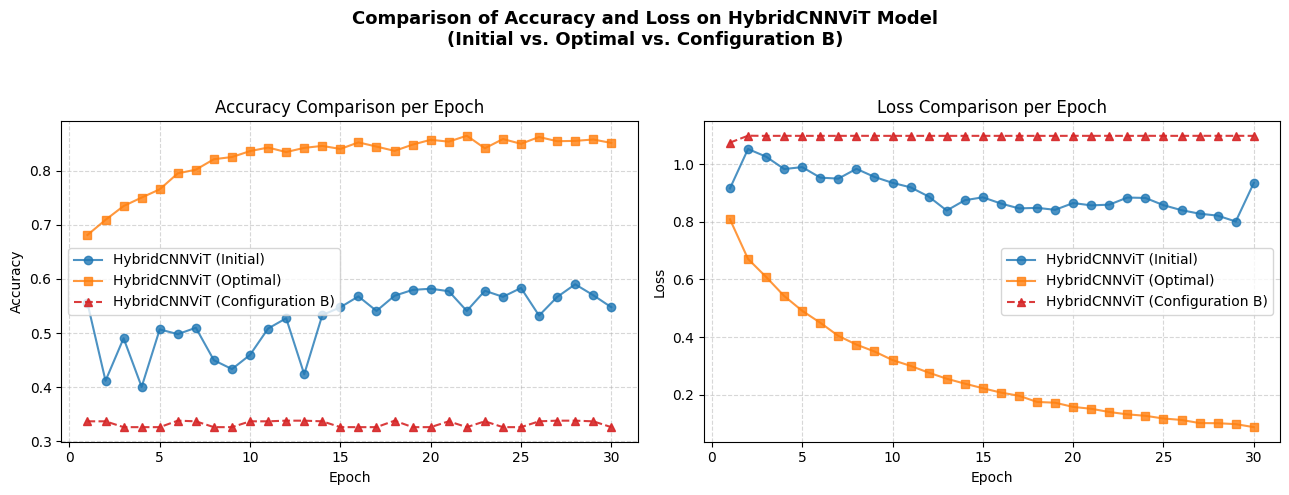

In [1]:
import matplotlib.pyplot as plt

# === Data (Sama seperti sebelumnya) ===
epochs = list(range(1, 31))

# HybridCNNViT (Awal / Initial)
loss_awal = [
    0.9162, 1.0530, 1.0264, 0.9835, 0.9901,
    0.9536, 0.9502, 0.9842, 0.9560, 0.9355,
    0.9199, 0.8880, 0.8394, 0.8752, 0.8853,
    0.8637, 0.8468, 0.8487, 0.8419, 0.8654,
    0.8573, 0.8598, 0.8845, 0.8831, 0.8580,
    0.8406, 0.8284, 0.8217, 0.8013, 0.9352
]
acc_awal = [
    0.5552, 0.4116, 0.4903, 0.4002, 0.5067,
    0.4979, 0.5097, 0.4496, 0.4332, 0.4595,
    0.5083, 0.5273, 0.4236, 0.5331, 0.5477,
    0.5678, 0.5409, 0.5690, 0.5798, 0.5820,
    0.5774, 0.5409, 0.5782, 0.5670, 0.5834,
    0.5323, 0.5666, 0.5902, 0.5700, 0.5477
]

# HybridCNNViT (Optimal)
loss_opt = [
    0.8090, 0.6713, 0.6088, 0.5427, 0.4912,
    0.4498, 0.4041, 0.3739, 0.3500, 0.3202,
    0.3000, 0.2766, 0.2554, 0.2384, 0.2224,
    0.2073, 0.1963, 0.1748, 0.1722, 0.1575,
    0.1511, 0.1399, 0.1317, 0.1267, 0.1173,
    0.1123, 0.1015, 0.1009, 0.0978, 0.0873
]
acc_opt = [
    0.6815, 0.7095, 0.7351, 0.7508, 0.7660,
    0.7956, 0.8024, 0.8218, 0.8258, 0.8368,
    0.8434, 0.8350, 0.8428, 0.8464, 0.8408,
    0.8529, 0.8452, 0.8372, 0.8488, 0.8577,
    0.8543, 0.8653, 0.8420, 0.8591, 0.8503,
    0.8629, 0.8551, 0.8557, 0.8583, 0.8519
]

# HybridCNNViT (Configuration B)
loss_baru = [1.0752,1.0992,1.0986,1.0988,1.0987,1.0987,1.0987,1.0988,1.0987,1.0987,
             1.0987,1.0987,1.0987,1.0987,1.0987,1.0987,1.0987,1.0987,1.0986,1.0988,
             1.0987,1.0988,1.0986,1.0988,1.0987,1.0987,1.0988,1.0988,1.0988,1.0987]
acc_baru  = [0.3365,0.3365,0.3257,0.3257,0.3257,0.3377,0.3365,0.3257,0.3257,0.3365,
             0.3365,0.3377,0.3377,0.3365,0.3257,0.3257,0.3257,0.3377,0.3257,0.3257,
             0.3365,0.3257,0.3365,0.3257,0.3257,0.3365,0.3377,0.3377,0.3365,0.3257]

# === Plot Side-by-Side ===
plt.figure(figsize=(13,5))

# --- Accuracy Plot ---
ax1 = plt.subplot(1,2,1)
# Note: Colors swapped to match your original image (Awal=Blue, Optimal=Orange)
ax1.plot(epochs, acc_awal, label="HybridCNNViT (Initial)", marker='o', color='tab:blue', alpha=0.8)
ax1.plot(epochs, acc_opt, label="HybridCNNViT (Optimal)", marker='s', color='tab:orange', alpha=0.8)
ax1.plot(epochs, acc_baru, label="HybridCNNViT (Configuration B)", marker='^', linestyle='--', color='tab:red', alpha=0.9)

ax1.set_title("Accuracy Comparison per Epoch")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend()

# --- Loss Plot ---
ax2 = plt.subplot(1,2,2)
# Note: Colors swapped to match your original image (Awal=Blue, Optimal=Orange)
ax2.plot(epochs, loss_awal, label="HybridCNNViT (Initial)", marker='o', color='tab:blue', alpha=0.8)
ax2.plot(epochs, loss_opt, label="HybridCNNViT (Optimal)", marker='s', color='tab:orange', alpha=0.8)
ax2.plot(epochs, loss_baru, label="HybridCNNViT (Configuration B)", marker='^', linestyle='--', color='tab:red', alpha=0.9)

ax2.set_title("Loss Comparison per Epoch")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Loss")
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

# --- Main Title ---
plt.suptitle("Comparison of Accuracy and Loss on HybridCNNViT Model\n(Initial vs. Optimal vs. Configuration B)", fontsize=13, fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.94])
plt.show()

Uji REAL-TIME DATASET

In [19]:
# =============================================
# FINAL EMOTIV EEG FINE-TUNE (DWT + 2D CNN + ViT)
# =============================================
import os, glob
import numpy as np
import pandas as pd
import pywt
from scipy.interpolate import griddata
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter

# ===== KONFIGURASI =====
FS = 128
WIN_SEC = 5
STEP_SEC = 2.5  # overlap 50%
RESIZE = 32
IDX2NAME = ["Negatif","Netral","Positif"]

TARGET_CHANNELS = ["FT7","FT8","T7","C5","C6","T8","TP7","CP5","CP6","TP8","P7","P8"]
CHANNEL_MAP = {
    "FT7":"EEG.F7","FT8":"EEG.F8","T7":"EEG.T7",
    "C5":"EEG.FC5","C6":"EEG.FC6","T8":"EEG.T8",
    "TP7":"EEG.P7","CP5":"EEG.P7","CP6":"EEG.P8",
    "TP8":"EEG.P8","P7":"EEG.P7","P8":"EEG.P8"
}
channel_coords = {
    "FT7":(-0.8,0.6),"FT8":(0.8,0.6),"T7":(-1.0,0.3),
    "C5":(-0.5,0.2),"C6":(0.5,0.2),"T8":(1.0,0.3),
    "TP7":(-0.9,-0.2),"CP5":(-0.4,-0.3),"CP6":(0.4,-0.3),
    "TP8":(0.9,-0.2),"P7":(-0.7,-0.6),"P8":(0.7,-0.6)
}

# ===== PREPROCESSING =====
def align_channels_emotiv(df, ch_map, target_ch):
    for tgt, src in ch_map.items():
        df[tgt] = df[src].astype(float) if src in df.columns else 0.0
    return df

def normalize_emotiv_segment(seg):
    seg = (seg - 4200.0)/200.0
    seg = (seg - seg.mean(axis=1,keepdims=True))/(seg.std(axis=1,keepdims=True)+1e-6)
    return seg

def segment_quality_ok(df, start, end, min_overall=3.0):
    for col in ["CQ.Overall","EQ.OVERALL","EQ.Overall"]:
        if col in df.columns:
            try:
                q = df[col].iloc[start:end].astype(float).mean()
                return q >= min_overall
            except Exception:
                return True
    return True

def extract_windows_from_csv(csv_path, fs=FS, win_sec=WIN_SEC, step_sec=STEP_SEC):
    df = pd.read_csv(csv_path, skiprows=1)
    df = align_channels_emotiv(df, CHANNEL_MAP, TARGET_CHANNELS)
    data = df[TARGET_CHANNELS].values.T
    win = int(fs*win_sec); step = int(fs*step_sec)
    segs=[]
    for start in range(0, data.shape[1]-win+1, step):
        end = start+win
        if not segment_quality_ok(df,start,end): continue
        segs.append(data[:,start:end])
    return segs

# ===== FITUR DWT-DE =====
def extract_dwt_de(segment, wavelet="db4", level=5):
    n_ch,_ = segment.shape
    feats = np.zeros((n_ch,5),dtype=np.float32)
    logp = lambda x: np.log(np.var(x)+1e-6)
    for ch in range(n_ch):
        cA5,cD5,cD4,cD3,cD2,cD1 = pywt.wavedec(segment[ch],wavelet=wavelet,level=level)
        feats[ch,0]=logp(cA5); feats[ch,1]=logp(cD5); feats[ch,2]=logp(cD4)
        feats[ch,3]=logp(cD3); feats[ch,4]=logp(np.hstack([cD2,cD1]))
    return feats

def generate_topomap(values, grid_res=32):
    coords=np.array([channel_coords[ch] for ch in TARGET_CHANNELS])
    xi,yi=np.linspace(-1,1,grid_res),np.linspace(-1,1,grid_res)
    xx,yy=np.meshgrid(xi,yi)
    zi=griddata(coords,values,(xx,yy),method="linear",fill_value=np.nan)
    return np.nan_to_num(zi)

def eeg_to_topomap_image(feats, grid_res=32):
    return np.stack([generate_topomap(feats[:,b],grid_res=grid_res) for b in range(feats.shape[1])],axis=0).astype(np.float32)

# ===== DATASET =====
class SEEDTopomapDataset(torch.utils.data.Dataset):
    def __init__(self, npz_file, indices=None, mean=None, std=None, resize=(32,32)):
        d=np.load(npz_file); X,y=d["X"],d["y"]
        self.X=X if indices is None else X[indices]
        self.y=y if indices is None else y[indices]
        self.mean,self.std,self.resize=mean,std,resize
    def __len__(self): return len(self.X)
    def __getitem__(self,idx):
        feats=(self.X[idx]-self.mean)/(self.std+1e-6)
        topo=eeg_to_topomap_image(feats,grid_res=self.resize[0])
        return torch.tensor(topo,dtype=torch.float32),torch.tensor(int(self.y[idx]),dtype=torch.long)

# ===== MODEL =====
class DeepCNNBackbone(nn.Module):
    def __init__(self,in_channels=5,out_channels=256):
        super().__init__()
        self.features=nn.Sequential(
            nn.Conv2d(in_channels,64,3,padding=1),nn.BatchNorm2d(64),nn.ReLU(),nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1),nn.BatchNorm2d(128),nn.ReLU(),nn.MaxPool2d(2),
            nn.Conv2d(128,256,3,padding=1),nn.BatchNorm2d(256),nn.ReLU(),nn.MaxPool2d(2),
            nn.Conv2d(256,512,3,padding=1),nn.BatchNorm2d(512),nn.ReLU(),nn.AdaptiveAvgPool2d((8,8))
        )
        self.proj=nn.Conv2d(512,out_channels,1)
    def forward(self,x): return self.proj(self.features(x))

class HybridCNNViT_SimplePE(nn.Module):
    def __init__(self,in_channels=5,emb_dim=128,num_heads=2,num_layers=1,num_classes=3,dropout=0.0):
        super().__init__()
        self.backbone=DeepCNNBackbone(in_channels=in_channels,out_channels=emb_dim)
        self.cls_token=nn.Parameter(torch.randn(1,1,emb_dim)*0.02)
        self.pos_embed=nn.Parameter(torch.zeros(1,65,emb_dim))
        enc=nn.TransformerEncoderLayer(d_model=emb_dim,nhead=num_heads,dim_feedforward=emb_dim*2,
                                       dropout=dropout,activation="gelu",batch_first=True)
        self.transformer=nn.TransformerEncoder(enc,num_layers=num_layers)
        self.mlp_head=nn.Sequential(nn.LayerNorm(emb_dim),nn.Linear(emb_dim,num_classes))
    def forward(self,x):
        B=x.size(0)
        feat=self.backbone(x)
        tokens=feat.flatten(2).permute(0,2,1)
        cls=self.cls_token.expand(B,-1,-1)
        toks=torch.cat([cls,tokens],dim=1)
        toks=toks+self.pos_embed[:,:toks.size(1),:]
        out=self.transformer(toks)
        return self.mlp_head(out[:,0,:])

# ===== CONVERT CSV → NPZ =====
def convert_emotiv_to_npz(folder_path,out_file,wavelet="db4"):
    all_X,all_y=[],[]
    label_map={"Sedih":0,"Netral":1,"Senang":2}
    for emo_class,label in label_map.items():
        class_dir=os.path.join(folder_path,emo_class)
        if not os.path.exists(class_dir): continue
        for fname in sorted(os.listdir(class_dir)):
            if not fname.endswith(".csv"): continue
            fpath=os.path.join(class_dir,fname)
            segs=extract_windows_from_csv(fpath)
            for seg in segs:
                seg=normalize_emotiv_segment(seg)
                feats=extract_dwt_de(seg,wavelet=wavelet)
                all_X.append(feats); all_y.append(label)
    os.makedirs(os.path.dirname(out_file),exist_ok=True)
    np.savez_compressed(out_file,X=np.array(all_X),y=np.array(all_y))
    print(f"[✅] Saved {out_file} | X={len(all_X)} samples")

# ===== SEMI-FREEZE FINE-TUNE =====
def fine_tune_emotiv_light(model_path,npz_file,lr=3e-5,epochs=5,batch_size=8,resize=32):
    device="cuda" if torch.cuda.is_available() else "cpu"
    d=np.load(npz_file); X,y=d["X"],d["y"]
    idx=np.arange(len(X)); np.random.shuffle(idx)
    split=int(0.8*len(X)); train_idx,test_idx=idx[:split],idx[split:]
    mean,std=X[train_idx].mean(axis=0),X[train_idx].std(axis=0)+1e-6
    cw=Counter(y[train_idx].tolist()); total=sum(cw.values())
    class_weights=torch.tensor([total/(cw.get(c,1)) for c in range(3)],dtype=torch.float32,device=device)
    train_set=SEEDTopomapDataset(npz_file,train_idx,mean,std,(resize,resize))
    test_set =SEEDTopomapDataset(npz_file,test_idx, mean,std,(resize,resize))
    train_loader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
    test_loader =DataLoader(test_set,batch_size=batch_size,shuffle=False)

    model=HybridCNNViT_SimplePE()
    model.load_state_dict(torch.load(model_path,map_location=device))

    # semi-freeze
    freeze_layers=['features.0','features.1','features.2','features.3']
    for name,param in model.backbone.named_parameters():
        param.requires_grad = not any(name.startswith(fz) for fz in freeze_layers)

    model.to(device)
    opt=AdamW(filter(lambda p:p.requires_grad,model.parameters()),lr=lr,weight_decay=1e-4)
    loss_fn=nn.CrossEntropyLoss(weight=class_weights,label_smoothing=0.05)

    print("[ℹ] Fine-tune start (semi-freeze CNN)")
    for ep in range(epochs):
        model.train(); total_loss=0
        for xb,yb in train_loader:
            xb,yb=xb.to(device),yb.to(device)
            opt.zero_grad()
            loss=loss_fn(model(xb),yb)
            loss.backward(); opt.step()
            total_loss+=loss.item()
        avg_loss=total_loss/len(train_loader)
        model.eval(); all_preds,all_labels=[],[]
        with torch.no_grad():
            for xb,yb in test_loader:
                preds=model(xb.to(device)).argmax(1).cpu().numpy()
                all_preds.extend(preds); all_labels.extend(yb.numpy())
        acc=accuracy_score(all_labels,all_preds)
        print(f"[Calib] Epoch {ep+1}/{epochs} - Loss:{avg_loss:.4f} - Acc:{acc:.4f}")

    torch.save(model.state_dict(),"./hybrid_cnn_vit_emotiv_calib.pth")
    np.savez_compressed("./npz_output/emotiv_calib_stats.npz",mean=mean,std=std)
    print("[✅] Model tersimpan: hybrid_cnn_vit_emotiv_calib.pth")

# ===== EVALUASI REAL-TIME =====
def load_train_norm_stats(npz_file):
    d=np.load(npz_file); return d["mean"],d["std"]

def label_from_name(name):
    n=name.lower()
    if "sedih" in n: return 0
    if "netral" in n: return 1
    if "senang" in n: return 2
    return -1

def predict_file(model,csv_path,mean,std,fs=FS,win_sec=WIN_SEC,step_sec=STEP_SEC,resize=RESIZE,device=None):
    if device is None: device="cuda" if torch.cuda.is_available() else "cpu"
    model.eval(); segs=extract_windows_from_csv(csv_path,fs,win_sec,step_sec)
    alpha=0.5; ema_logits=None
    with torch.no_grad():
        for seg in segs:
            seg=normalize_emotiv_segment(seg)
            feats=extract_dwt_de(seg)
            feats=(feats-mean)/(std+1e-6)
            topo=eeg_to_topomap_image(feats,grid_res=resize)
            X=torch.tensor(topo[None,...],dtype=torch.float32,device=device)
            logits=model(X).squeeze(0).cpu().numpy()
            ema_logits=logits if ema_logits is None else alpha*ema_logits+(1-alpha)*logits
    probs=F.softmax(torch.tensor(ema_logits),dim=0).numpy()
    return int(np.argmax(probs)),probs

def evaluate_realtime_folder(model,patterns,fs=FS,win_sec=WIN_SEC,step_sec=STEP_SEC,resize=RESIZE,npz_train_stats="./npz_output/emotiv_calib_stats.npz"):
    device="cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    mean,std=load_train_norm_stats(npz_train_stats)
    files=[]
    for pat in patterns: files.extend(glob.glob(pat))
    files=sorted(files)
    if not files:
        print("❌ Tidak menemukan file real-time."); return
    all_true,all_pred=[],[]
    print("=== HASIL UJI REAL-TIME (Emotiv) ===")
    for f in files:
        true_label=label_from_name(os.path.basename(f))
        pred,probs=predict_file(model,f,mean,std,fs,win_sec,step_sec,resize,device)
        all_true.append(true_label); all_pred.append(pred)
        print(f"{os.path.basename(f):<20} → Pred: {IDX2NAME[pred]:7s} (p={probs[pred]:.2f}) | Label: {IDX2NAME[true_label]}")
    acc=accuracy_score(all_true,all_pred)*100
    print(f"\nAkurasi Real-time (file-level): {acc:.2f}%")
    print("Confusion Matrix:\n",confusion_matrix(all_true,all_pred))
    print("\nClassification Report:")
    print(classification_report(all_true,all_pred,target_names=IDX2NAME))

# ===== RUN SEMUA =====
convert_emotiv_to_npz(
    folder_path="/home/revan/PKM/Emosi Revan/",
    out_file="./npz_output/emotiv_revan_dwt_de.npz"
)

fine_tune_emotiv_light(
    model_path="./hybrid_cnn_vit_seed.pth",
    npz_file="./npz_output/emotiv_revan_dwt_de.npz",
    lr=3e-5, epochs=5, batch_size=8, resize=RESIZE
)

model=HybridCNNViT_SimplePE()
model.load_state_dict(torch.load("./hybrid_cnn_vit_emotiv_calib.pth",map_location="cpu"))
evaluate_realtime_folder(
    model,
    patterns=(
        "/home/revan/PKM/Emosi Revan/Sedih/*.csv",
        "/home/revan/PKM/Emosi Revan/Netral/*.csv",
        "/home/revan/PKM/Emosi Revan/Senang/*.csv"
    ),
    fs=FS,win_sec=WIN_SEC,step_sec=STEP_SEC,resize=RESIZE,
    npz_train_stats="./npz_output/emotiv_calib_stats.npz"
)


[✅] Saved ./npz_output/emotiv_revan_dwt_de.npz | X=590 samples
[ℹ] Fine-tune start (semi-freeze CNN)


/tmp/ipykernel_16429/3737168034.py:170: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,map_location=device))


[Calib] Epoch 1/5 - Loss:3.7418 - Acc:0.3559
[Calib] Epoch 2/5 - Loss:1.6907 - Acc:0.4915
[Calib] Epoch 3/5 - Loss:1.1106 - Acc:0.5593
[Calib] Epoch 4/5 - Loss:0.9213 - Acc:0.5847
[Calib] Epoch 5/5 - Loss:0.7852 - Acc:0.6356
[✅] Model tersimpan: hybrid_cnn_vit_emotiv_calib.pth
=== HASIL UJI REAL-TIME (Emotiv) ===


/tmp/ipykernel_16429/3737168034.py:265: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./hybrid_cnn_vit_emotiv_calib.pth",map_location="cpu"

Netral_1.csv         → Pred: Negatif (p=0.68) | Label: Netral
Netral_2.csv         → Pred: Netral  (p=0.92) | Label: Netral
Sedih_1.csv          → Pred: Negatif (p=0.66) | Label: Negatif
Sedih_2.csv          → Pred: Negatif (p=0.69) | Label: Negatif
Senang_1.csv         → Pred: Positif (p=0.73) | Label: Positif
Senang_2.csv         → Pred: Positif (p=0.97) | Label: Positif

Akurasi Real-time (file-level): 83.33%
Confusion Matrix:
 [[2 0 0]
 [1 1 0]
 [0 0 2]]

Classification Report:
              precision    recall  f1-score   support

     Negatif       0.67      1.00      0.80         2
      Netral       1.00      0.50      0.67         2
     Positif       1.00      1.00      1.00         2

    accuracy                           0.83         6
   macro avg       0.89      0.83      0.82         6
weighted avg       0.89      0.83      0.82         6



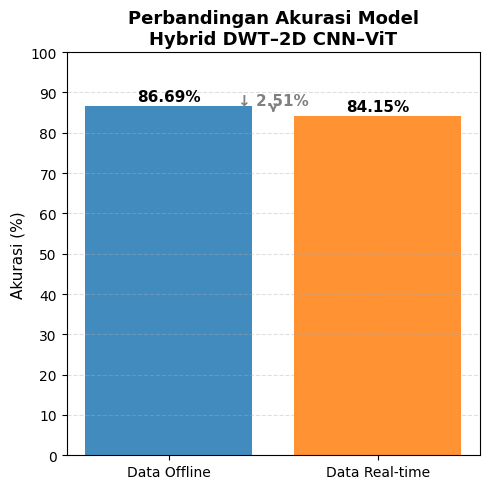

In [2]:
import matplotlib.pyplot as plt

# Data akurasi
labels = ["Data Offline", "Data Real-time"]
values = [86.69, 84.15]
colors = ['tab:blue', 'tab:orange']

# Plot batang
plt.figure(figsize=(5,5))
bars = plt.bar(labels, values, color=colors, alpha=0.85)

# Anotasi nilai di atas batang
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, value + 0.5, f"{value:.2f}%", 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Tambah anotasi selisih (tengah antara dua batang)
x_mid = (bars[0].get_x() + bars[1].get_x() + bars[1].get_width()) / 2
plt.annotate("↓ 2.51%", xy=(x_mid, 85.0), xytext=(x_mid, 87.0),
             arrowprops=dict(arrowstyle="->", color="gray", lw=1.5),
             ha='center', fontsize=11, color='gray', fontweight='bold')

# Gaya dan label
plt.title("Perbandingan Akurasi Model\nHybrid DWT–2D CNN–ViT", fontsize=13, fontweight='bold')
plt.ylabel("Akurasi (%)", fontsize=11)
plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
